# Running the cell-cell interaction and neighborhood analyses on all data

In [1]:
import os
import re
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sci
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline 
import scimap as sm

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.multitest import multipletests
from scipy.stats import poisson
import math
import random
import tqdm
from joblib import Parallel, delayed
from multiprocessing import Pool

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [105]:
adata = sc.read_h5ad('/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/outs/simple_h5ad/R1_reg1_statistics_growth5_comp.h5ad')
pred = pd.read_csv('/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/outs/simple_h5ad/R1_reg1_statistics_growth5_comp_pred.csv')
adata.obs = pred

In [2]:
def quick_process(ad):
    ad.X = ad.raw.X
    sc.pp.normalize_total(ad, target_sum=1000)
    sc.pp.log1p(ad)
    return(ad)

In [2]:
datRoot = '../../outs/simple_h5ad/'
datDict = {}
pat = re.compile('\w*_reg\w')
for d in os.listdir(datRoot):
    if os.path.isfile(os.path.join(datRoot, d)):
        fname, fext = os.path.splitext(d)
        sname = pat.search(fname)[0]
        if fext == '.csv' or fext == '.h5ad':
            if sname in datDict.keys():
                datDict[sname].append(os.path.join(datRoot, d))
            else:
                datDict[sname] = [os.path.join(datRoot, d)]

In [41]:
adata = sm.tl.spatial_distance(adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                               phenotype='cell_type_pred_knn', imageid='orig.ident')

Processing Image: SeuratProject


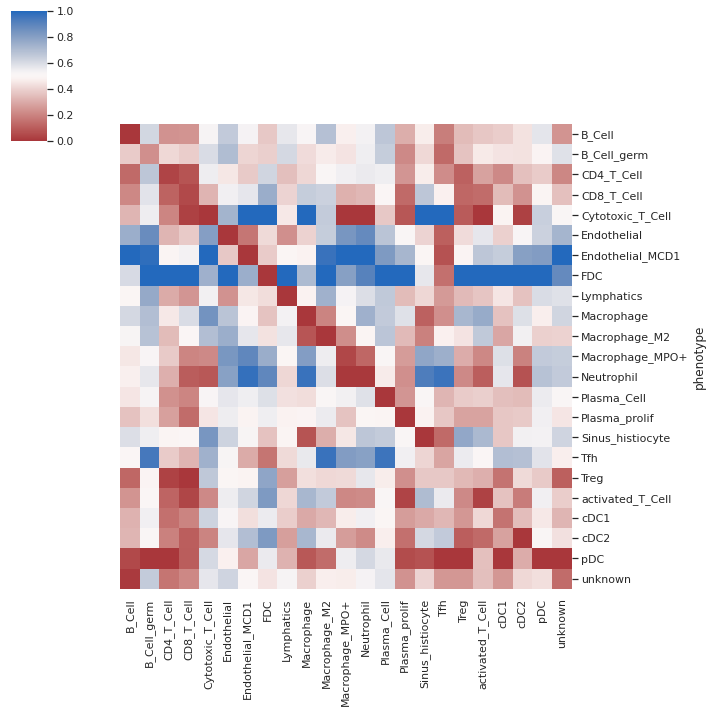

In [121]:
sm.pl.spatial_distance(adata, phenotype='cell_type_pred_knn', heatmap_standard_scale=1)

In [3]:
def save_dist_plot(pdata):
    fig, ax = plt.subplots(figsize=(10,8))
    pout = sm.pl.spatial_distance(pdata, phenotype='cell_type_pred_knn', heatmap_standard_scale=1, return_data=True)
    p = np.apply_along_axis(lambda x: x/x.max(), 0, pout)
    _ = sns.heatmap(p, xticklabels=pout.columns, yticklabels=pout.columns.to_list()[::-1],ax=ax)
    fig.savefig('test_dist.pdf', bbox_inches="tight")
    plt.ioff()
    plt.close()

In [8]:
def save_intxn_plot(pdata):
    fig, ax = plt.subplots(figsize=(10,8))
    pout = sm.pl.spatial_interaction(adata, return_data=True)
    p = np.apply_along_axis(lambda x: x/x.max(), 0, pout)
    _ = sns.heatmap(p, xticklabels=pout.columns, yticklabels=pout.columns.to_list()[::-1],ax=ax)
    fig.savefig('test_itxn.pdf', bbox_inches="tight")
    plt.ioff()
    plt.close() 
    return pout

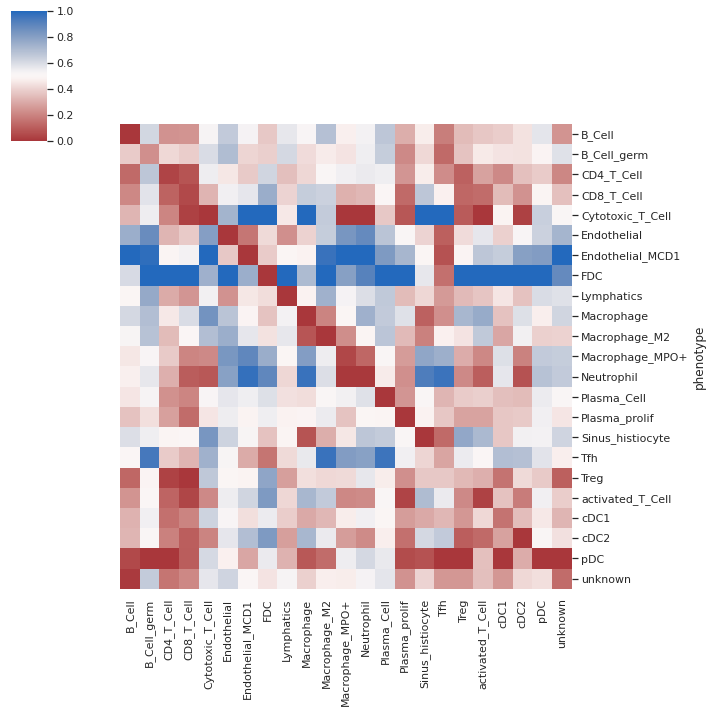

In [130]:
sm.pl.spatial_distance(adata, phenotype='cell_type_pred_knn', heatmap_standard_scale=1)
plt.savefig('test.pdf')

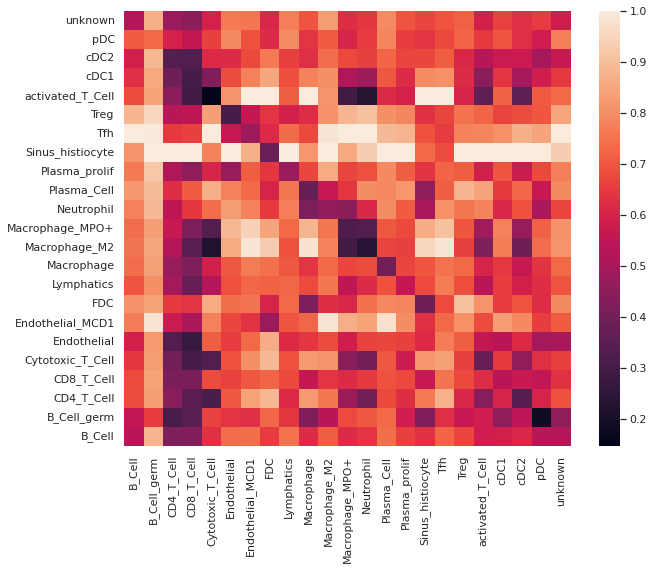

In [95]:
fig, ax = plt.subplots(figsize=(10,8))
p = np.apply_along_axis(lambda x: x/x.max(), 0, pout)
_ = sns.heatmap(p, xticklabels=pout.columns, yticklabels=pout.columns.to_list()[::-1],ax=ax)
fig.savefig('test.pdf', bbox_inches="tight")

## Preparing the scimap stuff

In [2]:
# parallelizing it

plt.ioff()
def neighborAnalysis(out_path, s):
    adata = sc.read_h5ad(os.path.join(out_path, s, 'gated_dat.h5ad'))
    print(s)
    # adata = sm.tl.spatial_distance(adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
    #                            phenotype='new_pheno', imageid='orig.ident')
    # sm.pl.spatial_distance(adata, phenotype='new_pheno', heatmap_standard_scale=1)
    # plt.savefig(os.path.join(out_path, s, 'dist_heatmap.pdf'))
    # plt.close()
    # adata = sm.tl.spatial_interaction(adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
    #                            phenotype='new_pheno', imageid='orig.ident',
    #                           method='radius', radius=50)
    # sm.pl.spatial_interaction(adata)
    # plt.savefig(os.path.join(out_path, s, 'intxn_heatmap.pdf'))
    # plt.close()
    
    # cell type abundance bar plot
    abun_dat = adata.obs.new_pheno.value_counts()
    abun_dat.plot.bar()
    plt.savefig(os.path.join(out_path, s, 'cell_type_abundance.png'), bbox_inches="tight")
    plt.close()
    
    # making pie chart
    keep = abun_dat > 0.01*adata.shape[0]
    pie_dat = abun_dat[keep]
    pie_dat['rare_cells'] = abun_dat[~keep].sum()
    plt.pie(pie_dat, labels=pie_dat.index)
    plt.savefig(os.path.join(out_path, s, 'cell_type_abundance_pie_graph.png'), bbox_inches="tight")
    plt.close()
    
    # save everything...
    # adata.write(os.path.join(out_path, s, 'gated_dat.h5ad'))
    
    return None
    

In [3]:
out_path = '../../outs/neighborhood_analysis/'
res = Parallel(1)(delayed(neighborAnalysis)(out_path, s) for s in os.listdir(out_path) if 'reg' in s)


K2_reg1
MCD1_reg1
K3_reg1
MCD3_reg2
K2_reg4
MCD1_reg3
K1_reg1
HVCD2_reg1
K2_reg3
R1_reg3
MCD4_reg3
K3_reg3
K3_reg5
R2_reg1
HVCD1_reg3
HVCD2_reg3
K3_reg4
MCD3_reg1
HVCD1_reg1
K1_reg3
MCD4_reg1
K1_reg2
MCD4_reg2
R1_reg2
K2_reg2
MCD4_reg4
K1_reg4
HVCD2_reg2
MCD3_reg3
HVCD1_reg4
HVCD2_reg5
MCD1_reg4
HVCD1_reg2
MCD1_reg2
K3_reg2
HVCD2_reg4
R1_reg1


  0%|          | 0/37 [00:00<?, ?it/s]

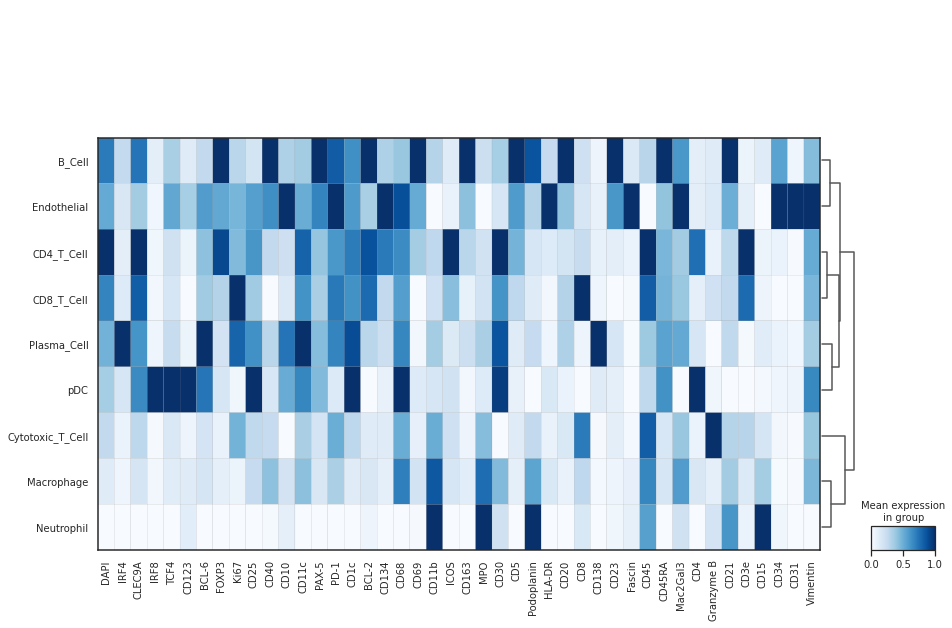

  3%|▎         | 1/37 [00:02<01:23,  2.31s/it]

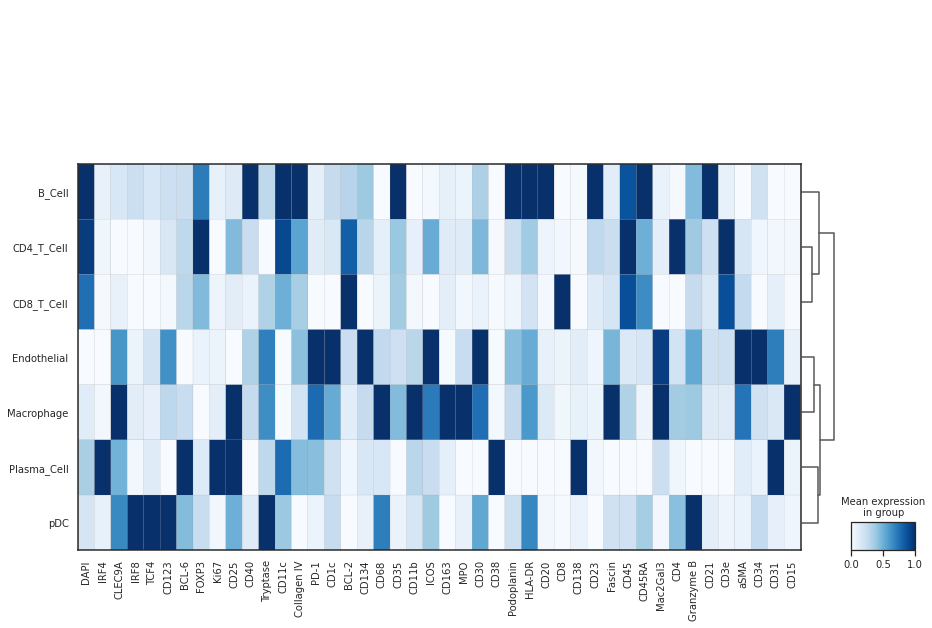

  5%|▌         | 2/37 [00:05<01:40,  2.88s/it]

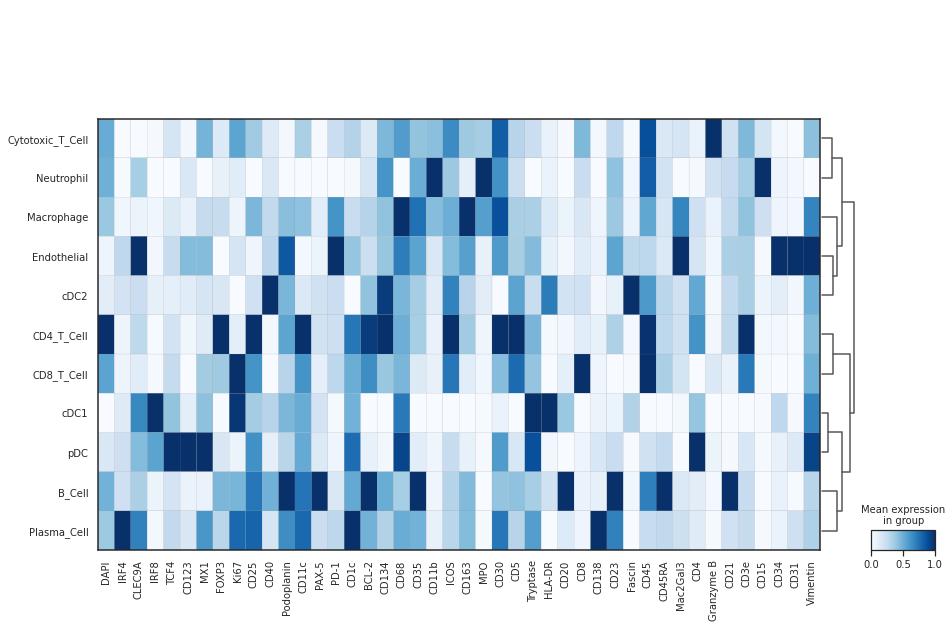

  8%|▊         | 3/37 [00:08<01:35,  2.82s/it]

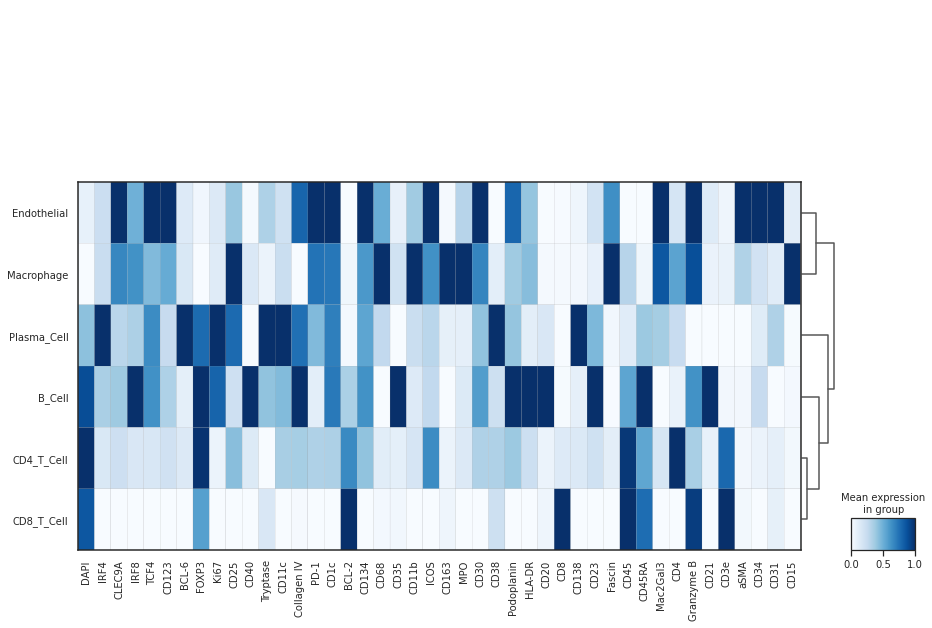

 11%|█         | 4/37 [00:11<01:34,  2.85s/it]

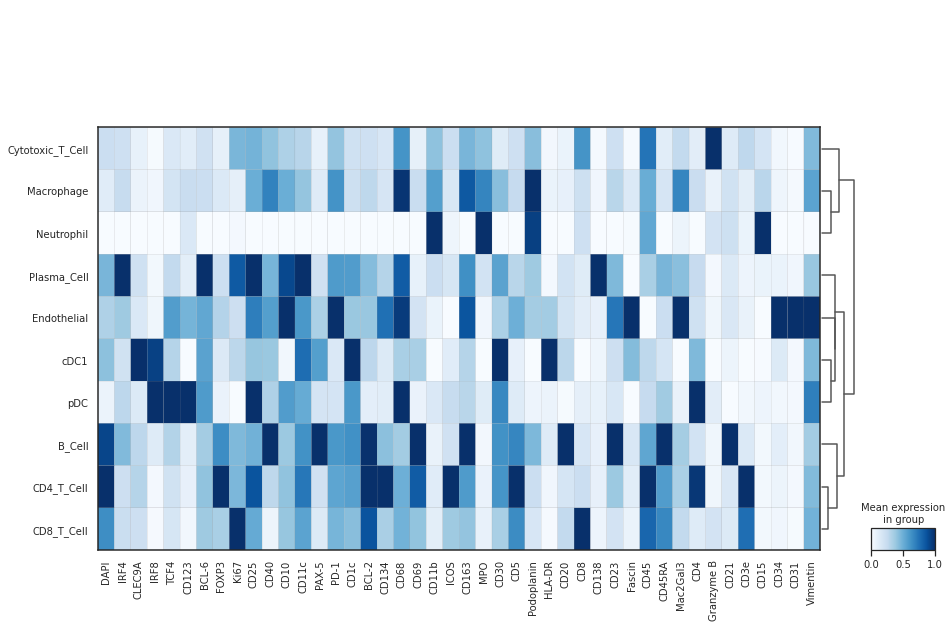

 14%|█▎        | 5/37 [00:13<01:22,  2.59s/it]

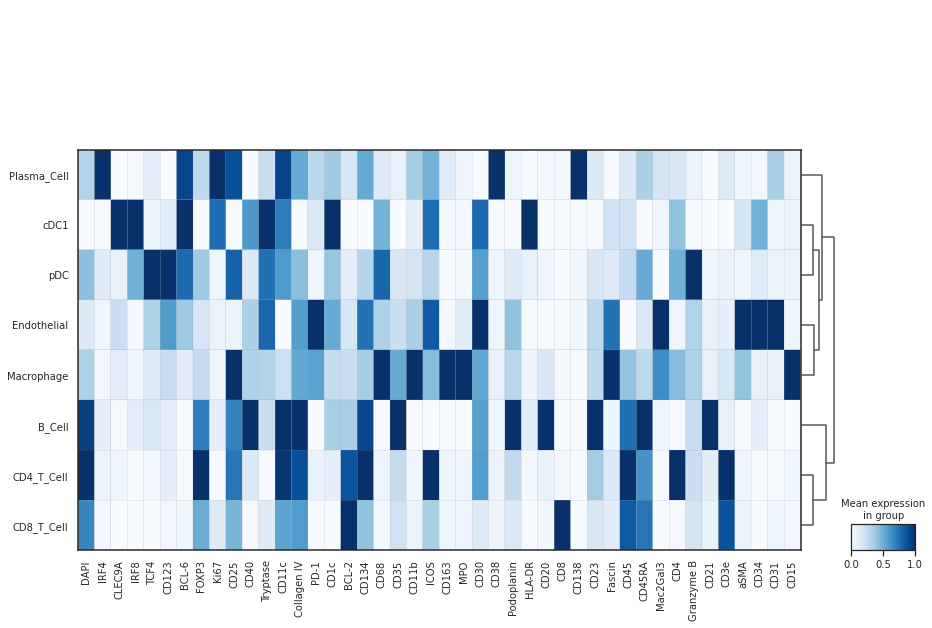

 16%|█▌        | 6/37 [00:16<01:27,  2.81s/it]

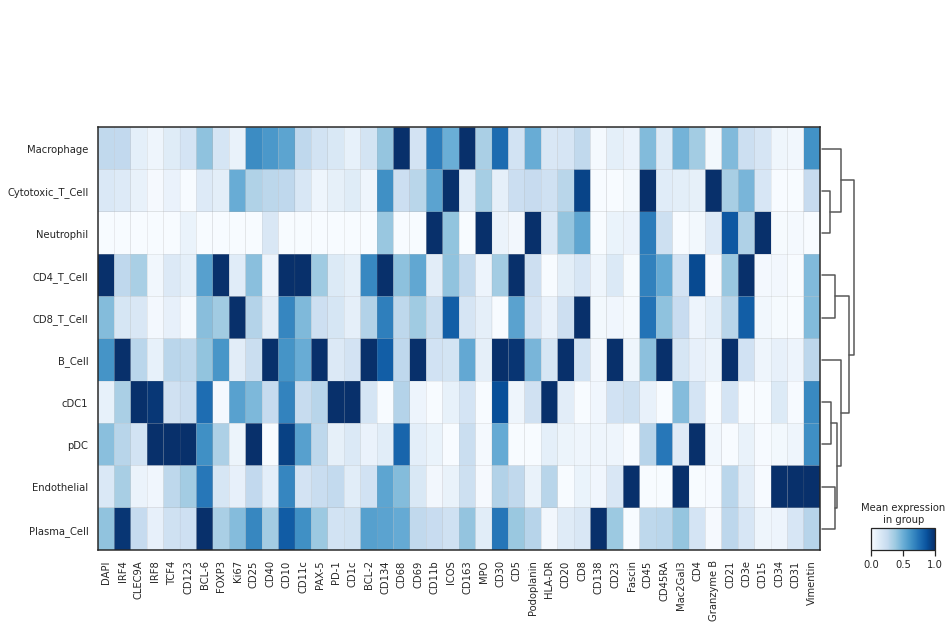

 19%|█▉        | 7/37 [00:18<01:15,  2.53s/it]

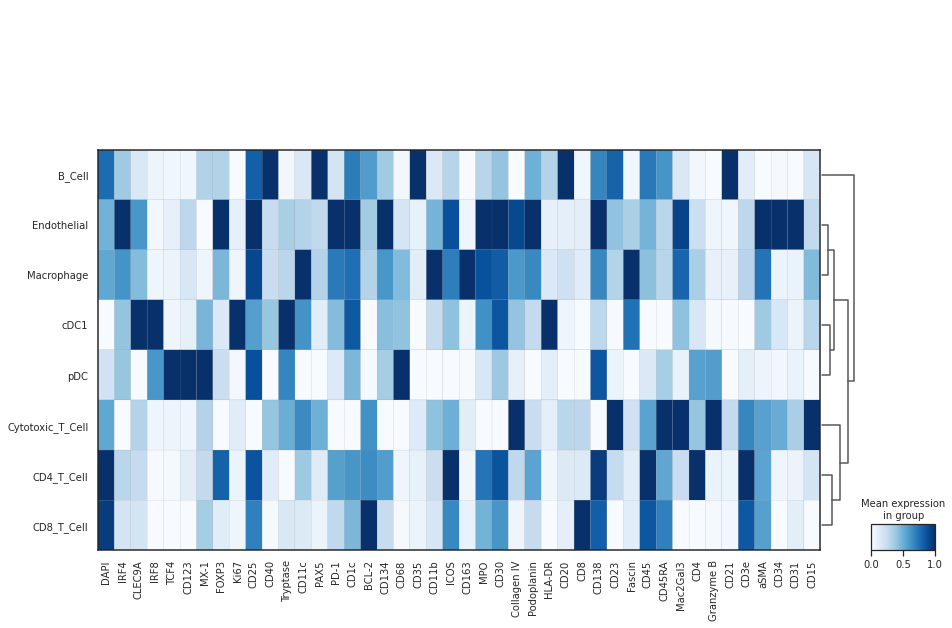

 22%|██▏       | 8/37 [00:20<01:07,  2.34s/it]

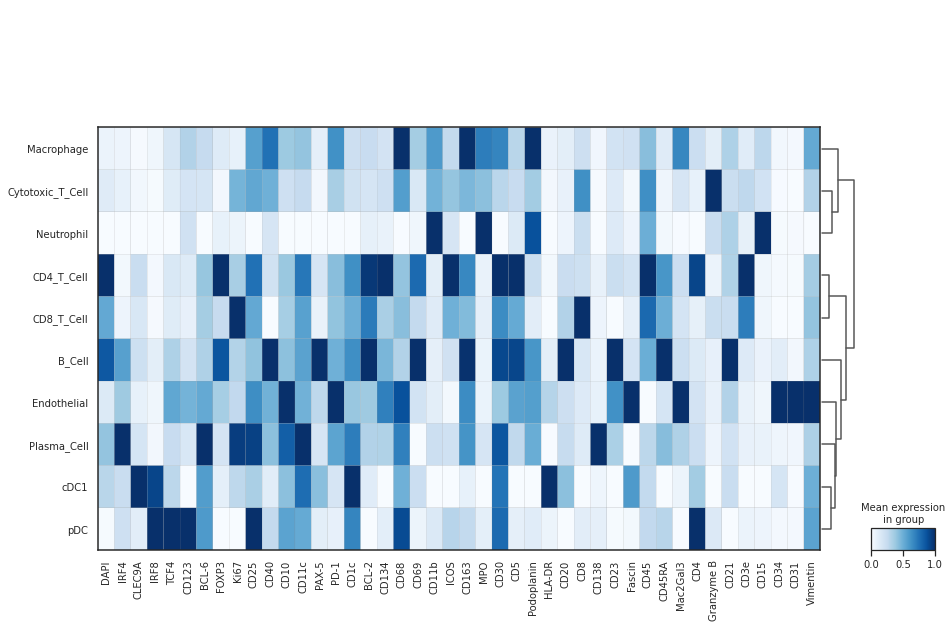

 24%|██▍       | 9/37 [00:22<01:06,  2.38s/it]

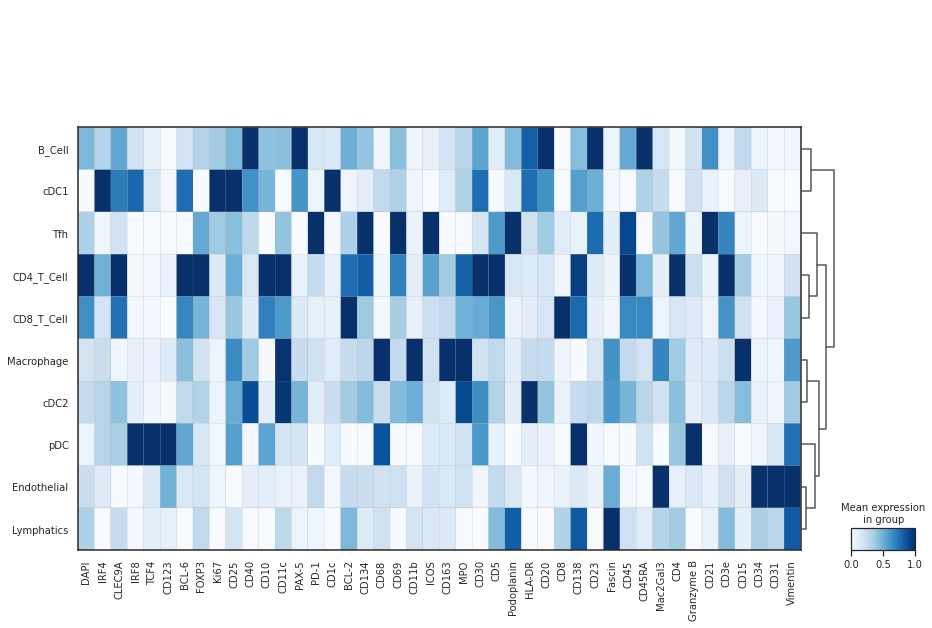

 27%|██▋       | 10/37 [00:25<01:05,  2.43s/it]

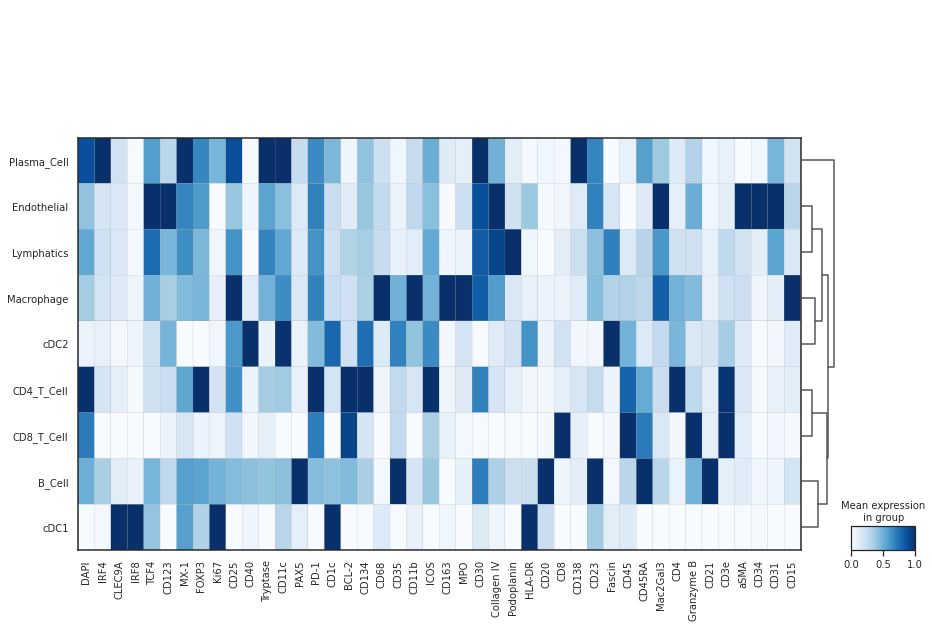

 30%|██▉       | 11/37 [00:28<01:08,  2.62s/it]

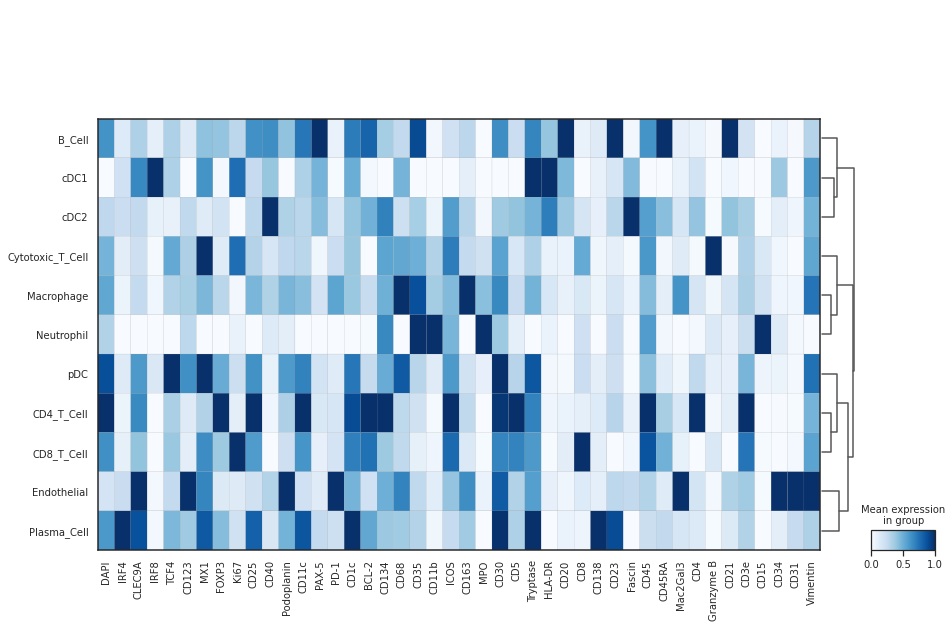

 32%|███▏      | 12/37 [00:30<01:00,  2.41s/it]

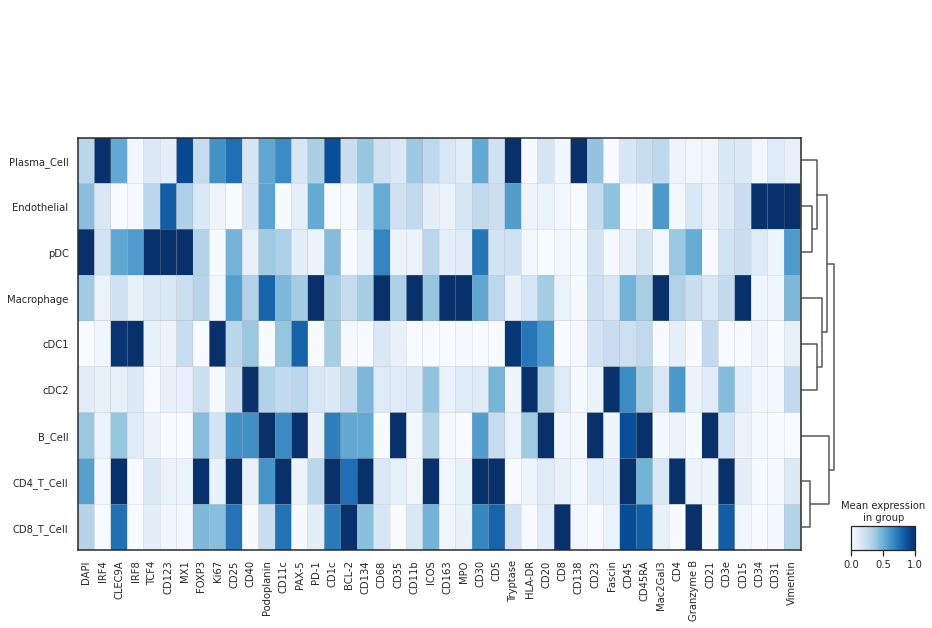

 35%|███▌      | 13/37 [00:32<00:54,  2.26s/it]

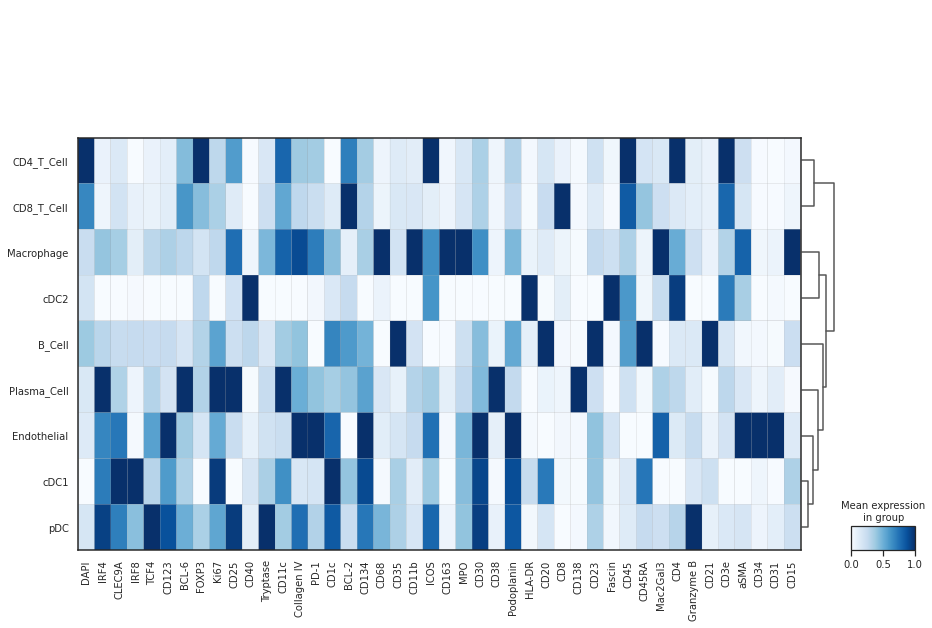

 38%|███▊      | 14/37 [00:34<00:50,  2.19s/it]

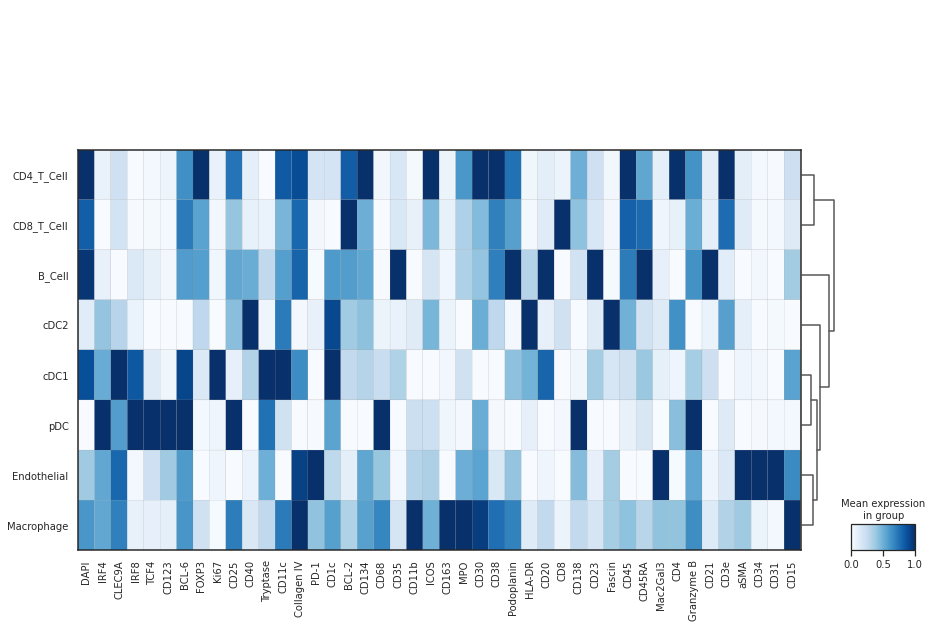

 41%|████      | 15/37 [00:37<00:52,  2.41s/it]

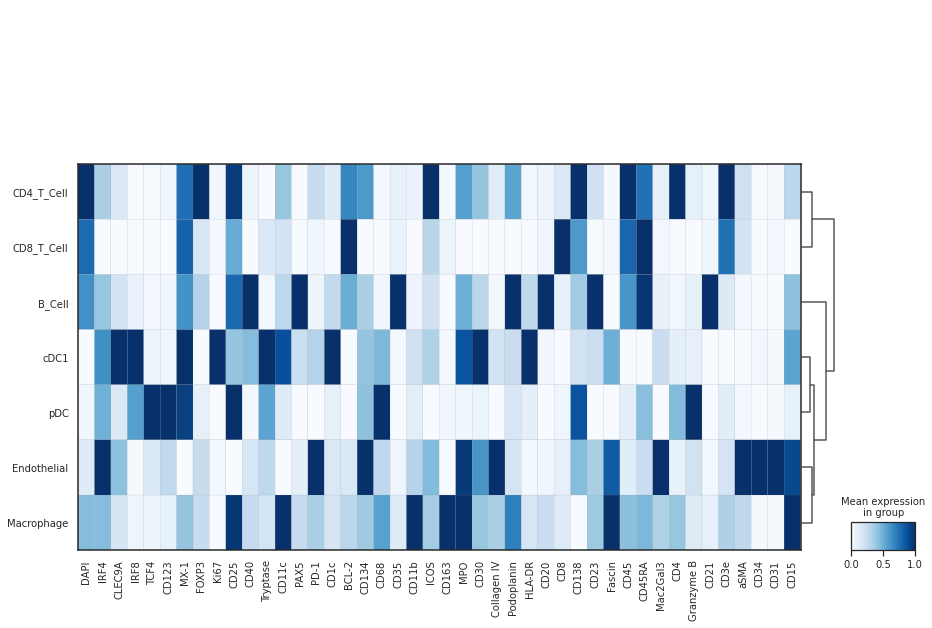

 43%|████▎     | 16/37 [00:39<00:48,  2.31s/it]

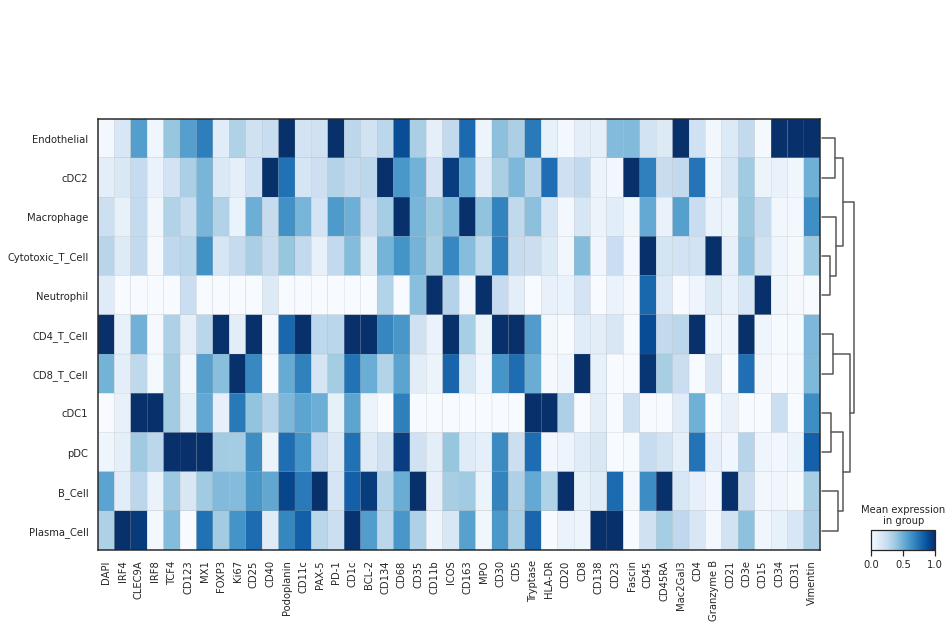

 46%|████▌     | 17/37 [00:41<00:44,  2.22s/it]

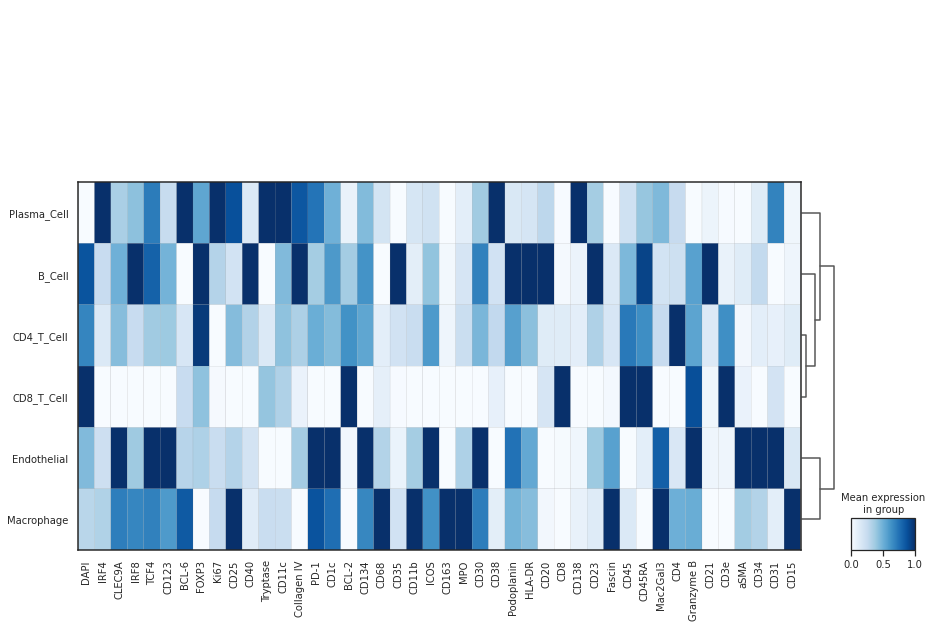

 49%|████▊     | 18/37 [00:43<00:39,  2.06s/it]

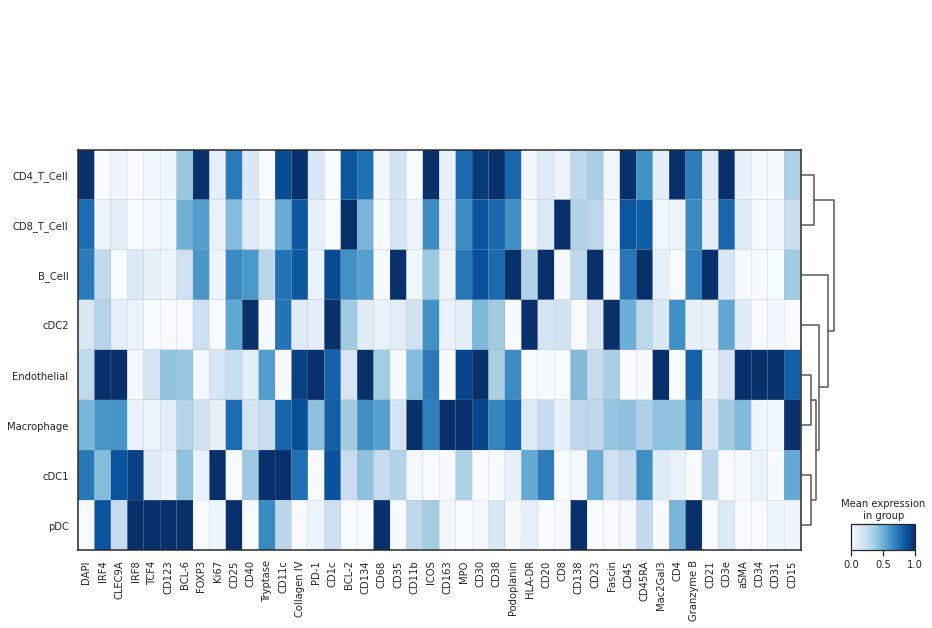

 51%|█████▏    | 19/37 [00:46<00:42,  2.38s/it]

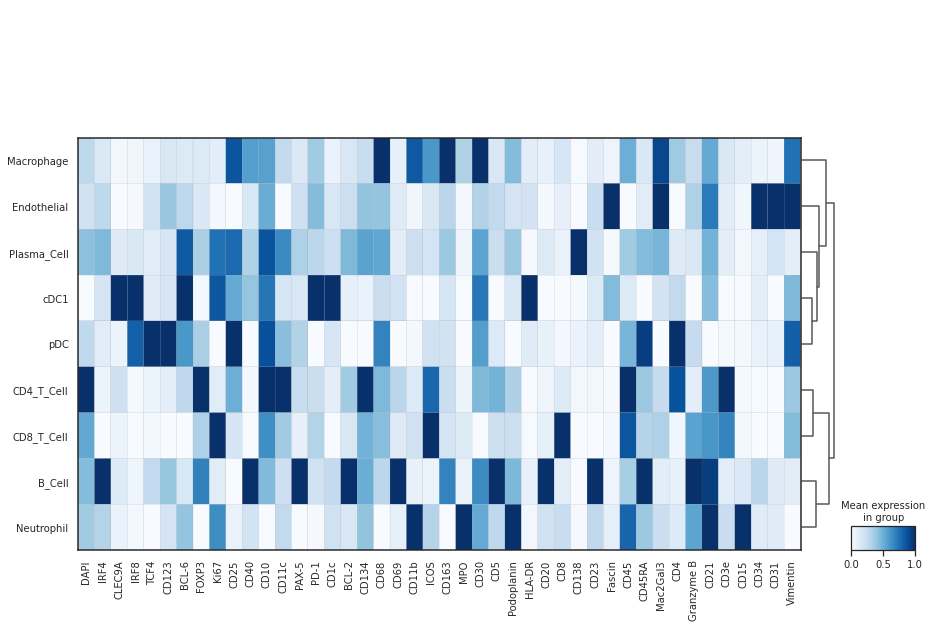

 54%|█████▍    | 20/37 [00:47<00:36,  2.16s/it]

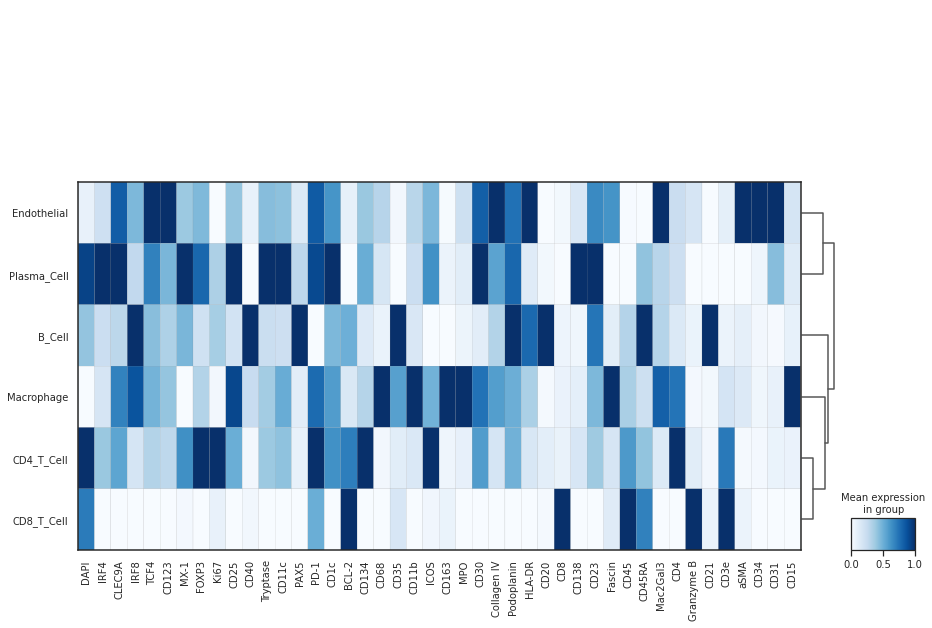

 57%|█████▋    | 21/37 [00:49<00:31,  1.98s/it]

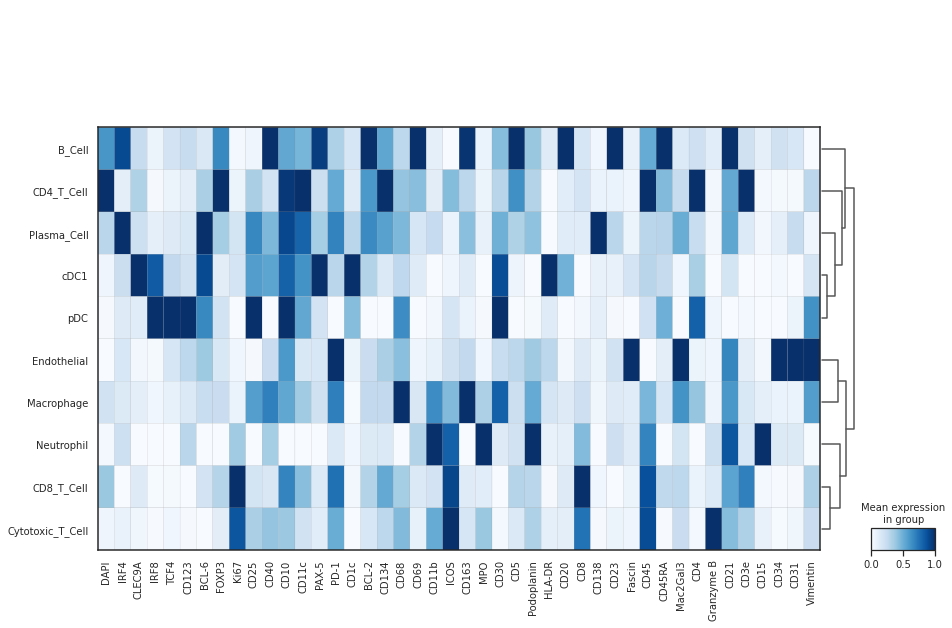

 59%|█████▉    | 22/37 [00:51<00:28,  1.92s/it]

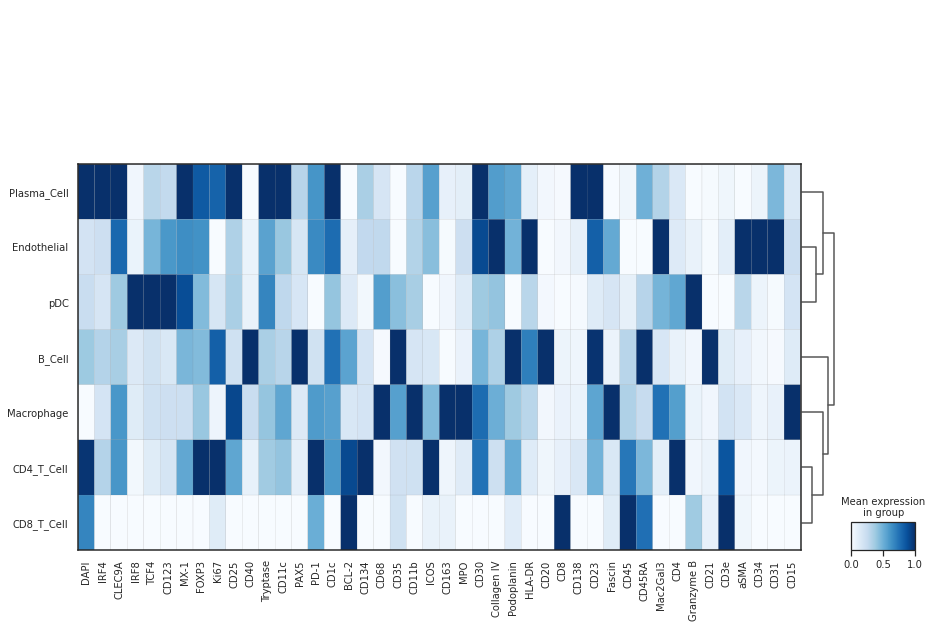

 62%|██████▏   | 23/37 [00:53<00:29,  2.12s/it]

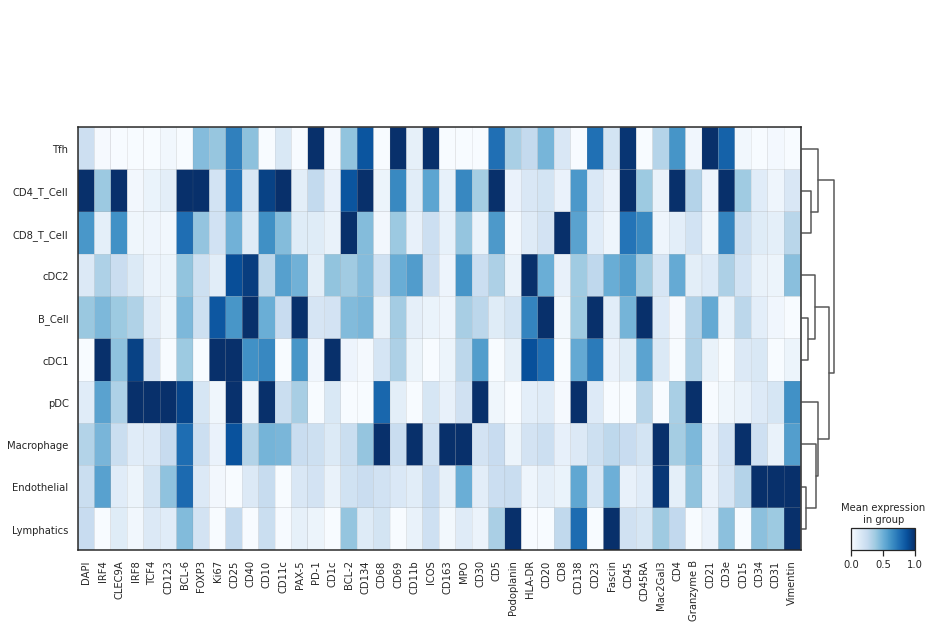

 65%|██████▍   | 24/37 [00:56<00:29,  2.24s/it]

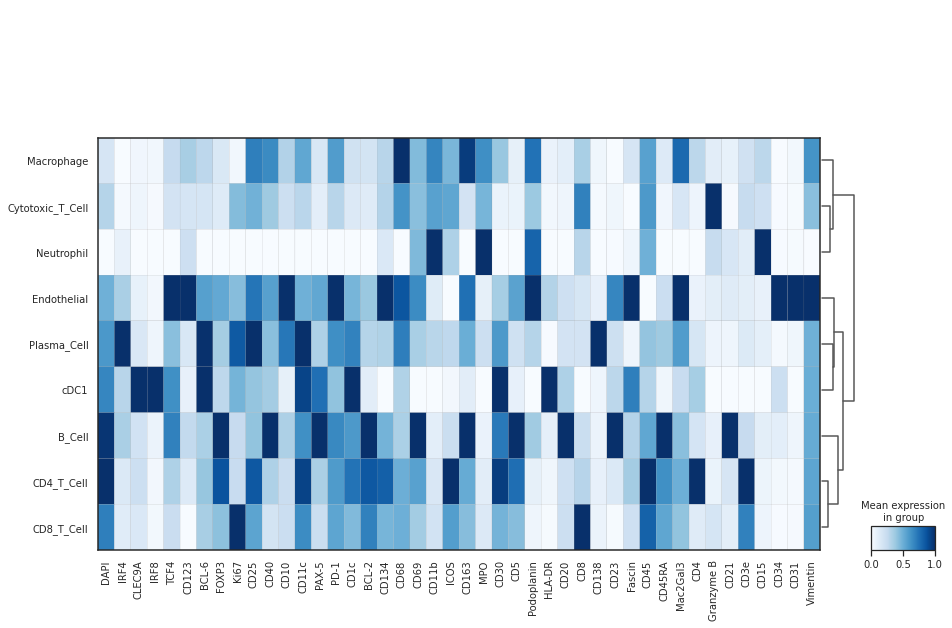

 68%|██████▊   | 25/37 [00:58<00:25,  2.16s/it]

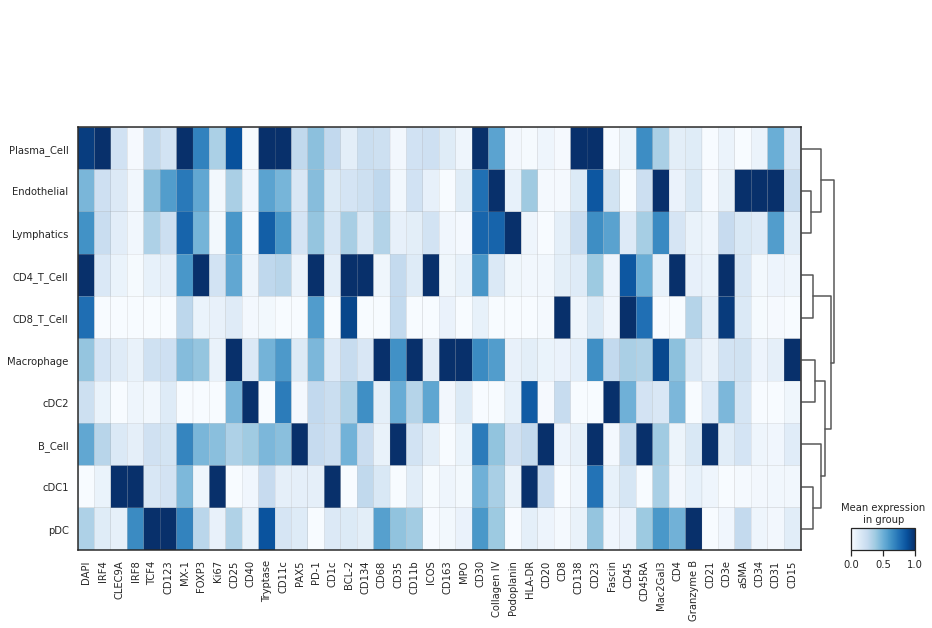

 70%|███████   | 26/37 [01:00<00:25,  2.29s/it]

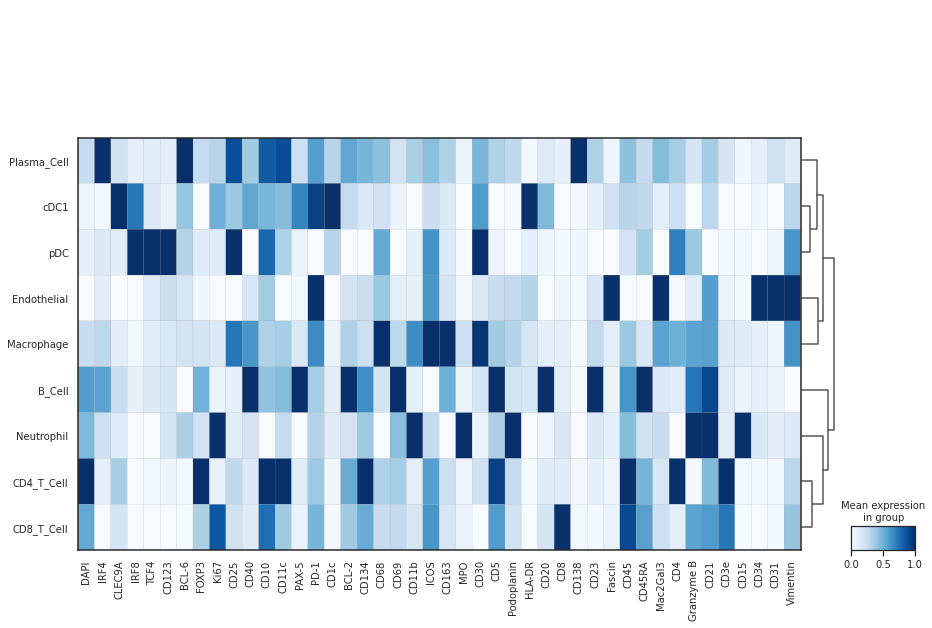

 73%|███████▎  | 27/37 [01:02<00:21,  2.13s/it]

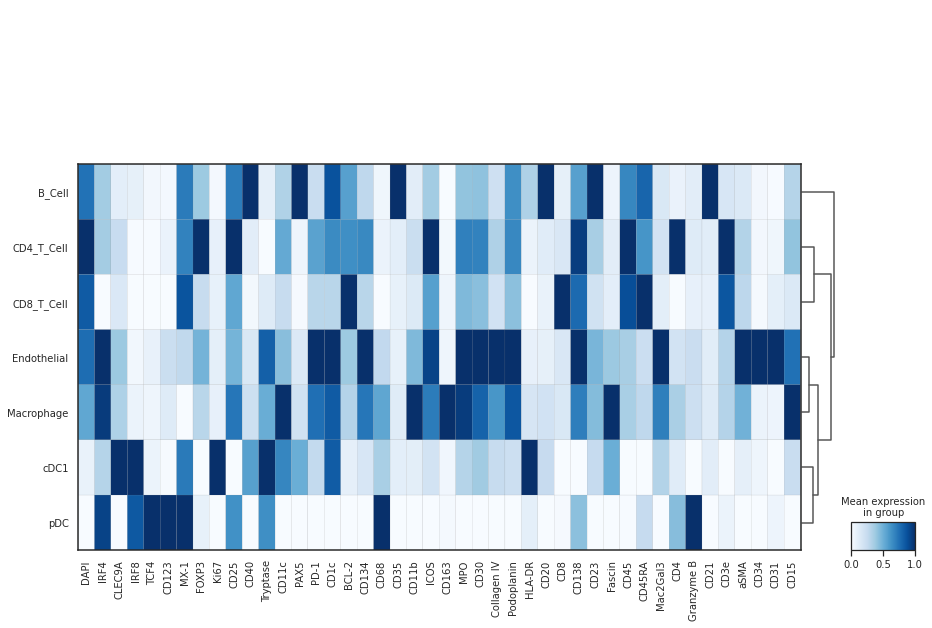

 76%|███████▌  | 28/37 [01:05<00:20,  2.24s/it]

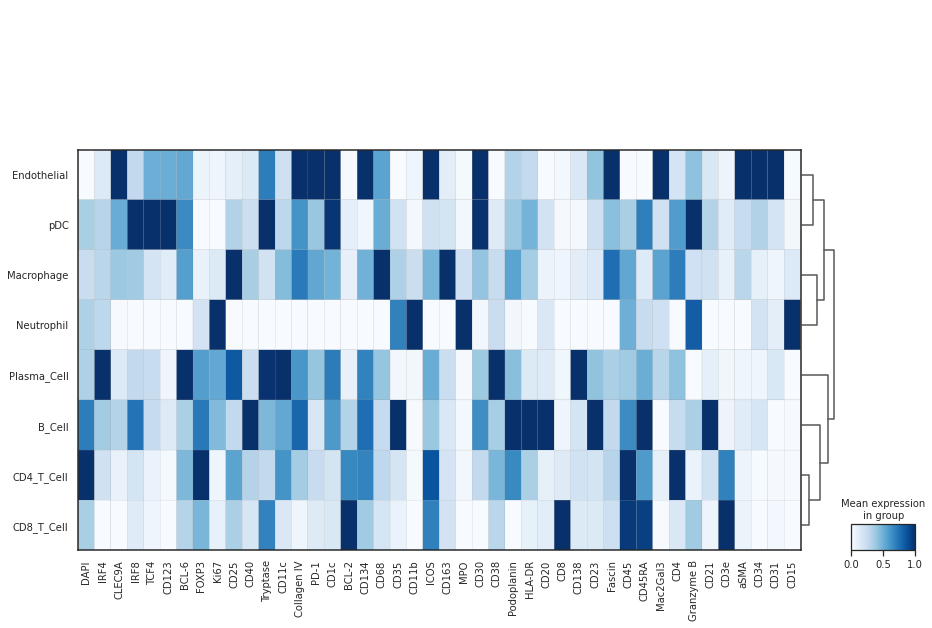

 78%|███████▊  | 29/37 [01:06<00:16,  2.12s/it]

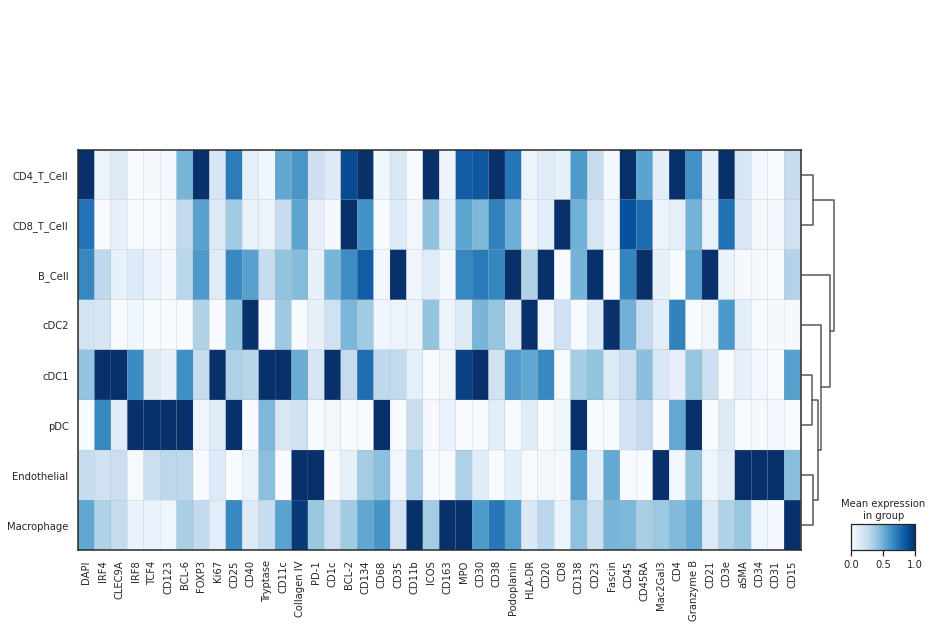

 81%|████████  | 30/37 [01:10<00:16,  2.40s/it]

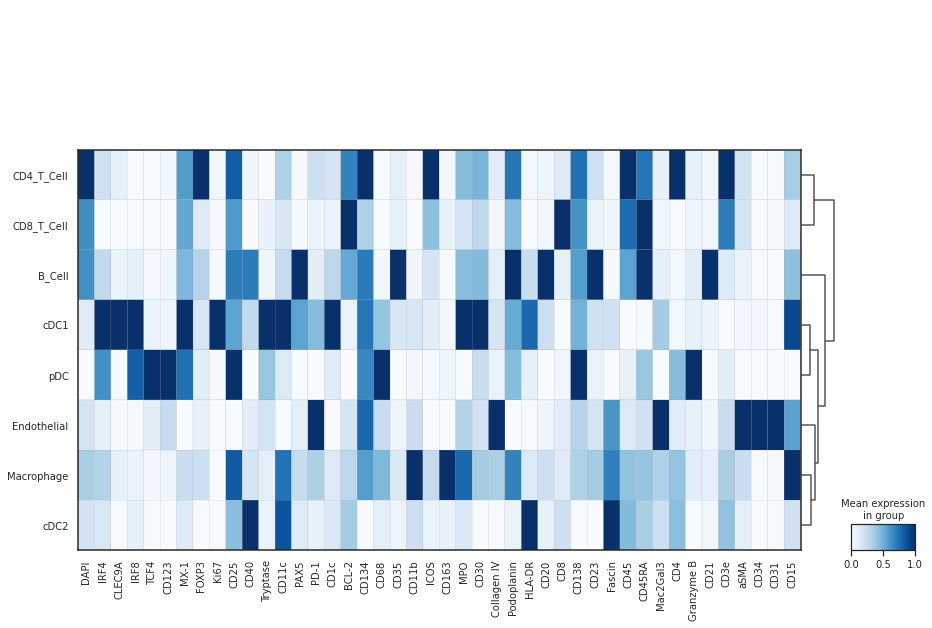

 84%|████████▍ | 31/37 [01:12<00:14,  2.47s/it]

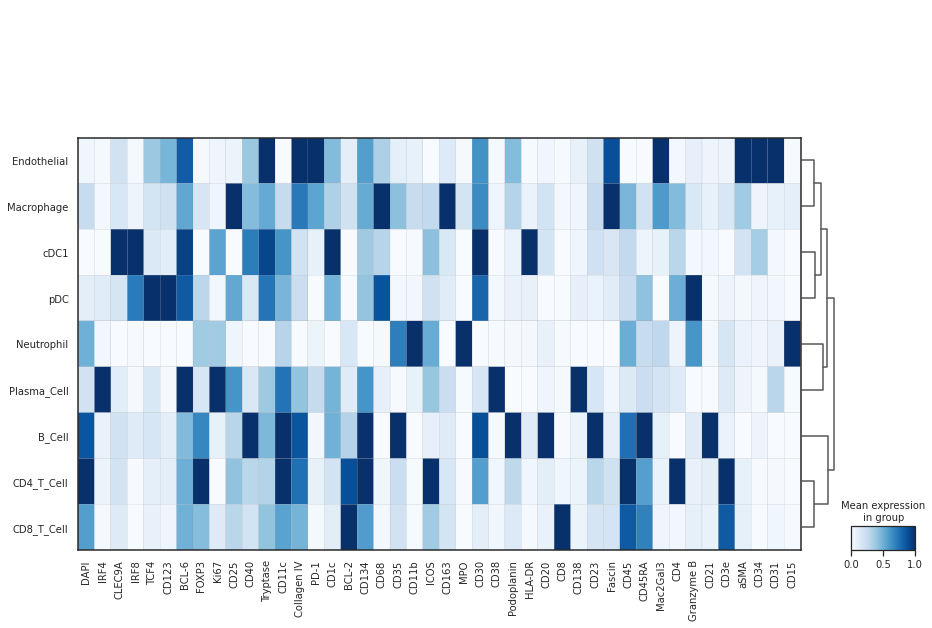

 86%|████████▋ | 32/37 [01:15<00:13,  2.63s/it]

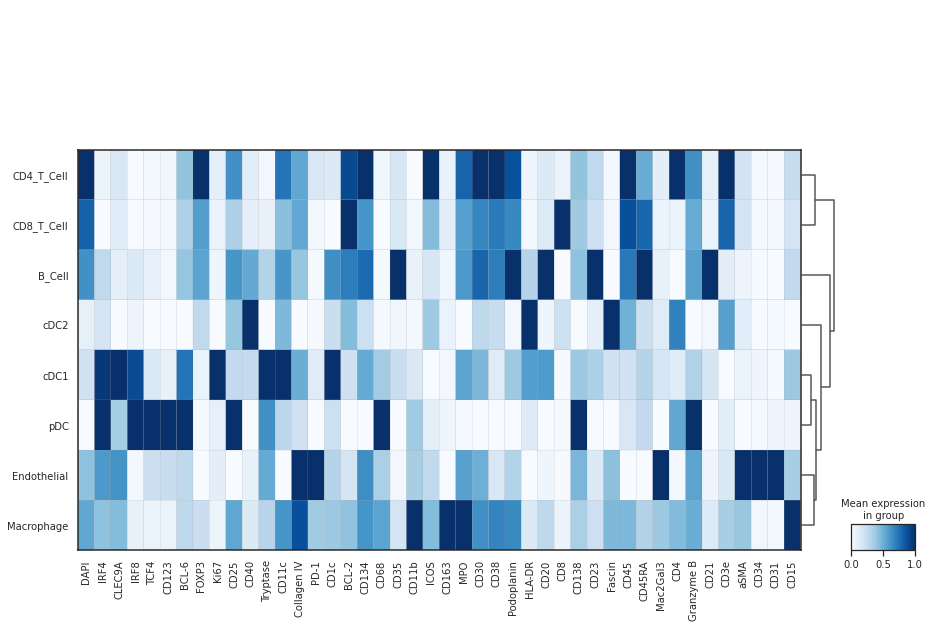

 89%|████████▉ | 33/37 [01:18<00:10,  2.69s/it]

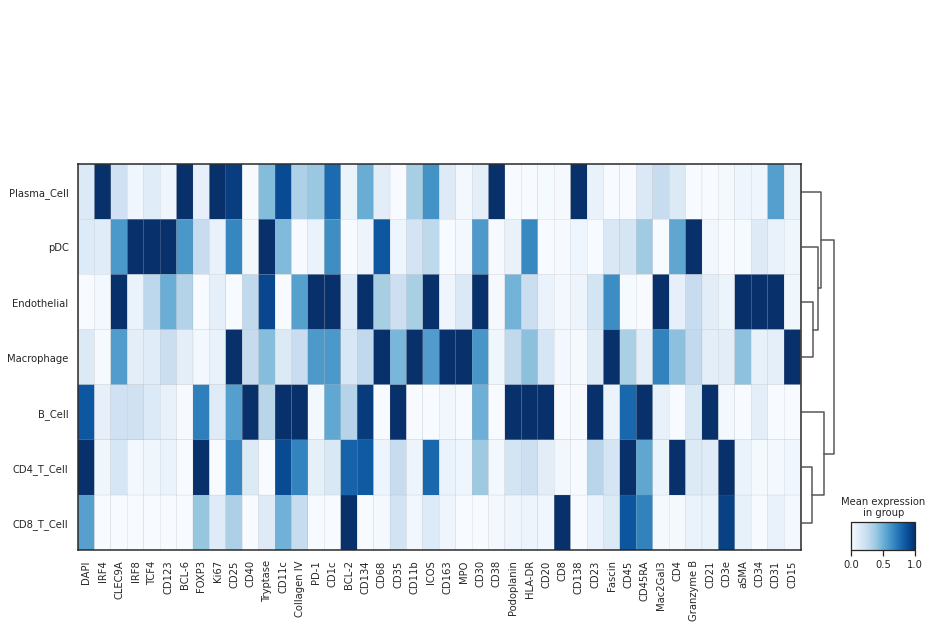

 92%|█████████▏| 34/37 [01:21<00:08,  2.83s/it]

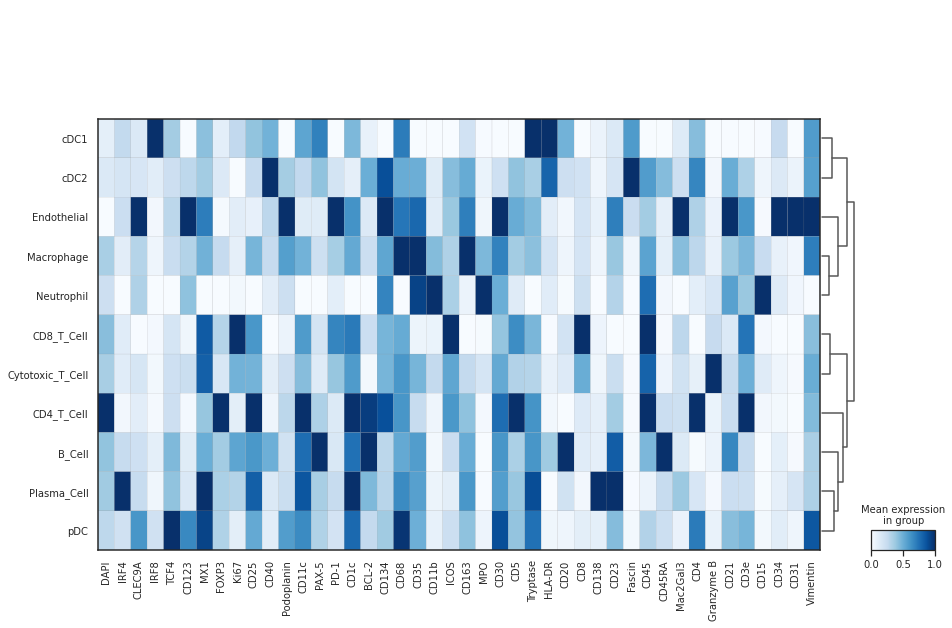

 95%|█████████▍| 35/37 [01:23<00:05,  2.51s/it]

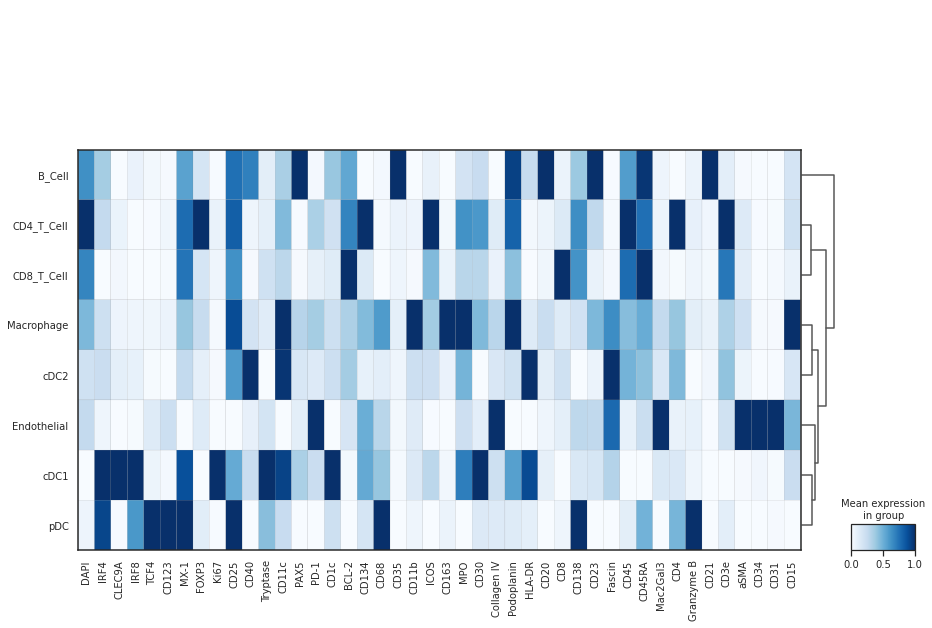

 97%|█████████▋| 36/37 [01:26<00:02,  2.54s/it]

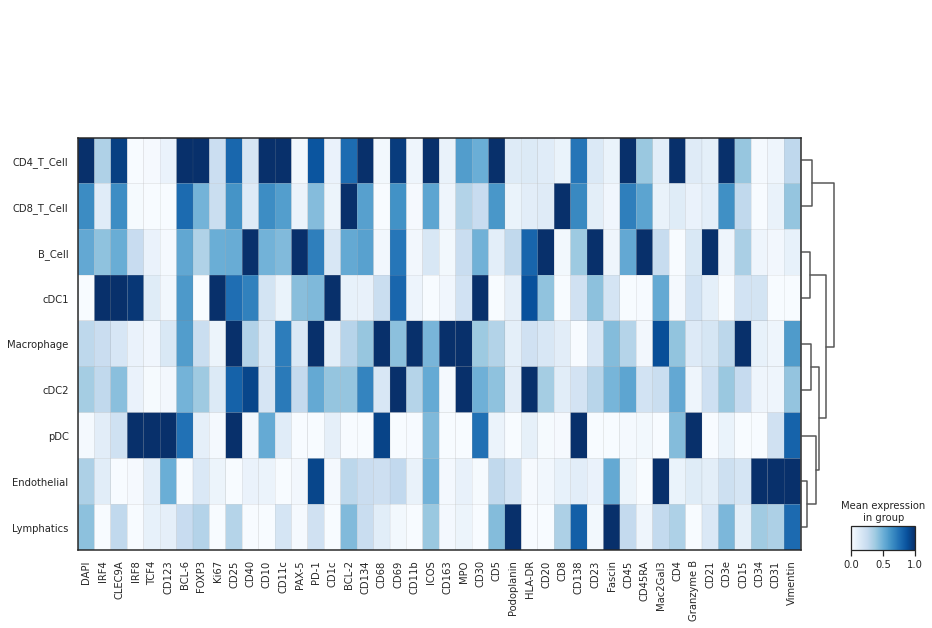

100%|██████████| 37/37 [01:28<00:00,  2.40s/it]


In [7]:
# forgot to do the heatmaps
out_path = '../../outs/neighborhood_analysis/'
in_paths = [d for d in os.listdir(out_path) if 'reg' in d]
for s in tqdm.tqdm(in_paths):
    adata = sc.read_h5ad(os.path.join(out_path, s, 'gated_dat.h5ad'))
    # adata = quick_process(adata)
    
    # a little cleaning...
    abun_dat = adata.obs.cell_type_pred_knn.value_counts()
    keep = abun_dat > 0.01*adata.shape[0]
    pie_dat = abun_dat[keep]
    adata_abun = adata[adata.obs['new_pheno'].isin(pie_dat.index),:].copy()
    # make heatmap
    sc.pp.scale(adata_abun, max_value=10)
    sc.tl.pca(adata_abun, svd_solver='arpack')
    adata_abun.obs['new_pheno'] = pd.Categorical(adata_abun.obs['new_pheno'])
    sc.tl.dendrogram(adata_abun, n_pcs=10, groupby='new_pheno')
    fig, ax = plt.subplots(figsize=(15,10))
    sc.pl.matrixplot(adata_abun, adata_abun.var_names, groupby='new_pheno', dendrogram=True, cmap='Blues',
                 use_raw=True, standard_scale='var', swap_axes=False, ax=ax)
    fig.savefig(os.path.join(out_path, s, 'marker_heatmap.pdf'), dpi=300)
    plt.close()

In [16]:
out_path = '../../outs/neighborhood_analysis/'
in_paths = [d for d in os.listdir(out_path) if 'reg' in d]
for s in tqdm.tqdm(in_paths):
    print(s)
    # if not os.path.isdir(os.path.join(out_path, s)):
    #     os.mkdir(os.path.join(out_path, s))
    # which_index = list(map(lambda x: 'csv' in x, paths))
    # if which_index[0]:
    #     adata = sc.read_h5ad(paths[1])
    #     pred = pd.read_csv(paths[0])
    #     adata.obs = pred
    # else:
    #     adata = sc.read_h5ad(paths[0])
    #     pred = pd.read_csv(paths[1])
    #     adata.obs = pred
    # if 'community_bar_plot_absolute.pdf' in os.listdir(os.path.join(out_path, s)):
    #     continue
    adata = sc.read_h5ad(os.path.join(out_path, s, 'gated_dat.h5ad'))
    
    adata = sm.tl.spatial_lda(adata, num_motifs=9, radius=30, 
                          imageid='orig.ident', x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                          phenotype='new_pheno')
    m = adata.uns['spatial_lda'].columns
    motifs = adata.uns['spatial_lda'].apply(lambda x: m[np.argmax(x)], axis=1)
    adata.obs['motif'] = motifs
    
    fig, ax = plt.subplots(figsize=(15,15))
    sm.pl.voronoi(adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
              color_by = 'motif', imageid='orig.ident',voronoi_edge_color='white', voronoi_line_width=0, **{'ax':ax})
    plt.savefig(os.path.join(out_path, s, 'voronoi.pdf'))
    plt.close()
    
    # making neigborhood bar charts...
    comp = adata.obs[['new_pheno','motif']].pivot_table(index='new_pheno',columns='motif', 
                                                      aggfunc=len, fill_value=0)
    # reorder cells based on abundance
    comp = comp.loc[adata.obs['new_pheno'].value_counts().index, :]
    
    # realtive abundance
    pdata = comp.apply(lambda x: x/x.sum(), axis=0)
    fig, ax = plt.subplots(figsize=(15,15))
    pdata.T.plot(kind='bar', stacked=True, **{'ax':ax})
    plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
    plt.savefig(os.path.join(out_path, s, 'community_bar_plot.pdf'), bbox_inches="tight")
    plt.close()
    
    # absolute abundance
    fig, ax = plt.subplots(figsize=(15,15))
    comp.T.plot(kind='bar', stacked=True, **{'ax':ax})
    plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
    plt.savefig(os.path.join(out_path, s, 'community_bar_plot_absolute.pdf'), bbox_inches="tight")
    plt.close()
    
    # motifs abun. bar plot
    adata.obs.motif.value_counts().plot.bar()
    plt.savefig(os.path.join(out_path, s, 'motif_abundance.png'), bbox_inches="tight")
    plt.close()
    
    # save everything...
    adata.write(os.path.join(out_path, s, 'gated_dat.h5ad'))
    

  0%|          | 0/37 [00:00<?, ?it/s]

K2_reg1
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.28950533572909176
Gathering the latent weights


  3%|▎         | 1/37 [02:50<1:42:30, 170.85s/it]

MCD1_reg1
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2643429309245756
Gathering the latent weights


  5%|▌         | 2/37 [11:11<3:32:50, 364.88s/it]

K3_reg1
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.19464413901040128
Gathering the latent weights


  8%|▊         | 3/37 [16:38<3:16:52, 347.41s/it]

MCD3_reg2
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.22085233426210438
Gathering the latent weights


 11%|█         | 4/37 [22:20<3:09:55, 345.30s/it]

K2_reg4
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2294988427949439
Gathering the latent weights


 14%|█▎        | 5/37 [26:55<2:50:39, 319.98s/it]

MCD1_reg3
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2671347107782138
Gathering the latent weights


 16%|█▌        | 6/37 [35:59<3:24:41, 396.19s/it]

K1_reg1
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.23111223556343885
Gathering the latent weights


 19%|█▉        | 7/37 [39:31<2:47:56, 335.87s/it]

HVCD2_reg1
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.32164384026562476
Gathering the latent weights


 22%|██▏       | 8/37 [43:01<2:23:05, 296.06s/it]

K2_reg3
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2544201234503291
Gathering the latent weights


 24%|██▍       | 9/37 [49:10<2:28:45, 318.78s/it]

R1_reg3
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.33007059697012586
Gathering the latent weights


 27%|██▋       | 10/37 [55:45<2:34:04, 342.40s/it]

MCD4_reg3
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.31106248668956227
Gathering the latent weights


 30%|██▉       | 11/37 [1:03:06<2:41:22, 372.41s/it]

K3_reg3
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2724267299574709
Gathering the latent weights


 32%|███▏      | 12/37 [1:06:54<2:16:51, 328.48s/it]

K3_reg5
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2602952182654732
Gathering the latent weights


 35%|███▌      | 13/37 [1:10:59<2:01:19, 303.30s/it]

R2_reg1
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2070646846458798
Gathering the latent weights


 38%|███▊      | 14/37 [1:15:18<1:51:05, 289.82s/it]

HVCD1_reg3
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.23179001500483942
Gathering the latent weights


 41%|████      | 15/37 [1:22:58<2:05:05, 341.16s/it]

HVCD2_reg3
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.22367180075822665
Gathering the latent weights


 43%|████▎     | 16/37 [1:27:49<1:54:05, 325.99s/it]

K3_reg4
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2771935995631798
Gathering the latent weights


 46%|████▌     | 17/37 [1:30:57<1:34:50, 284.52s/it]

MCD3_reg1
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.29871866942789516
Gathering the latent weights


 49%|████▊     | 18/37 [1:34:03<1:20:45, 255.01s/it]

HVCD1_reg1
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.32247430989497816
Gathering the latent weights


 51%|█████▏    | 19/37 [1:42:40<1:40:02, 333.48s/it]

K1_reg3
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.309256848698105
Gathering the latent weights


 54%|█████▍    | 20/37 [1:45:23<1:20:00, 282.39s/it]

MCD4_reg1
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.3490182162661565
Gathering the latent weights


 57%|█████▋    | 21/37 [1:47:41<1:03:43, 238.95s/it]

K1_reg2
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2205386186340065
Gathering the latent weights


 59%|█████▉    | 22/37 [1:51:05<57:07, 228.47s/it]  

MCD4_reg2
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.17929179647548987
Gathering the latent weights


 62%|██████▏   | 23/37 [1:58:18<1:07:37, 289.84s/it]

R1_reg2
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2845167713173849
Gathering the latent weights


 65%|██████▍   | 24/37 [2:03:57<1:06:00, 304.66s/it]

K2_reg2
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.22095178966183232
Gathering the latent weights


 68%|██████▊   | 25/37 [2:08:05<57:32, 287.69s/it]  

MCD4_reg4
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.17693918357827887
Gathering the latent weights


 70%|███████   | 26/37 [2:15:06<1:00:05, 327.76s/it]

K1_reg4
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2387469159230654
Gathering the latent weights


 73%|███████▎  | 27/37 [2:18:07<47:16, 283.62s/it]  

HVCD2_reg2
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.18405232153150708
Gathering the latent weights


 76%|███████▌  | 28/37 [2:24:27<46:54, 312.69s/it]

MCD3_reg3
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.22243038264545845
Gathering the latent weights


 78%|███████▊  | 29/37 [2:28:02<37:46, 283.27s/it]

HVCD1_reg4
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.3713673314261602
Gathering the latent weights


 81%|████████  | 30/37 [2:35:17<38:21, 328.72s/it]

HVCD2_reg5
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.25398570649310104
Gathering the latent weights


 84%|████████▍ | 31/37 [2:42:22<35:46, 357.73s/it]

MCD1_reg4
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.19344045867564696
Gathering the latent weights


 86%|████████▋ | 32/37 [2:51:01<33:51, 406.22s/it]

HVCD1_reg2
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.259435671519887
Gathering the latent weights


 89%|████████▉ | 33/37 [2:58:48<28:17, 424.46s/it]

MCD1_reg2
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.26464809847077897
Gathering the latent weights


 92%|█████████▏| 34/37 [3:07:31<22:41, 453.96s/it]

K3_reg2
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.24935883760701577
Gathering the latent weights


 95%|█████████▍| 35/37 [3:10:44<12:30, 375.47s/it]

HVCD2_reg4
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.22936848691919665
Gathering the latent weights


 97%|█████████▋| 36/37 [3:17:35<06:26, 386.29s/it]

R1_reg1
Processing: ['SeuratProject']
Identifying neighbours within 30 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.20608250130775932
Gathering the latent weights


100%|██████████| 37/37 [3:24:20<00:00, 331.37s/it]


In [15]:
# # replotting motif barplot to fit legend, and making cell type and motif abundance plot
# datadir = '/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis/'
# for d in tqdm.tqdm(os.listdir(datadir)):
#     adata = sc.read_h5ad(os.path.join(datadir, d, 'dat.h5ad'))
    
#     # motifs comp. bar plot
#     comp = adata.obs[['cell_type_pred_knn','motif']].pivot_table(index='cell_type_pred_knn',columns='motif', 
#                                                       aggfunc=len, fill_value=0)
#     pdata = comp.apply(lambda x: x/x.sum(), axis=0)

#     fig, ax = plt.subplots(figsize=(15,15))
#     pdata.T.plot(kind='bar', stacked=True, **{'ax':ax})
#     plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
#     plt.savefig(os.path.join(datadir, d, 'community_bar_plot.pdf'), bbox_inches="tight")
#     plt.close()
    
#     # motifs abun. bar plot
#     adata.obs.motif.value_counts().plot.bar()
#     plt.savefig(os.path.join(datadir, d, 'motif_abundance.png'), bbox_inches="tight")
#     plt.close()
    
#     # cell type abundance bar plot
#     adata.obs.cell_type_pred_knn.value_counts().plot.bar()
#     plt.savefig(os.path.join(datadir, d, 'cell_type_abundance.png'), bbox_inches="tight")
#     plt.close()

  0%|          | 0/51 [00:00<?, ?it/s]/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

  2%|▏         | 1/51 [00:02<02:23,  2.86s/it]/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

  4%|▍         | 2/51 [00:05<02:22,  2.91s/it]/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

  8%|▊         | 4/51 [00:16<03:57,  5.06s/it]/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

 10%|▉         | 5/51 [00:19<03:04,  4.01s/it]/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModifica

## Preparing the cell-cell G-function stuff

**Need to run self-self distances separately, use pysal**

Use B-cells as control itxn partner

KFD and R itxns of interest:
 - M2-CD8
 - pDC-(CD4/CD8/cytotoxic/activated)
 - M2-cytotoxic
 - pDC-pDC
     - this porbably have to be separate
 - (pDC/M2)-B-cell
HVCD, R, and MCD itxns of interest:
 - endo-(CD4/CD8/cytotoxic/activated)
 - endo-(Macrophage_MPO/Macrophage)
 - Macrophage...
 
...I'm just going to make all of them
savefig

In [9]:
def single_csr(V, p, r):
    density = p/V
    probs = 2*(density*math.pi)*(r**2)*math.exp(-density*(r**2))
    return probs
make_csr = np.vectorize(single_csr)

In [10]:
def simulate_positions(ad, c1, c2):
    dat = ad[ad.obs['new_pheno'].isin([c1,c2]),:].copy()
    ymin = np.floor(dat.obs['Absolute.Y'].min()).astype(int)
    ymax = np.floor(dat.obs['Absolute.Y'].max()).astype(int)
    xmin = np.floor(dat.obs['Absolute.X'].min()).astype(int)
    xmax = np.floor(dat.obs['Absolute.X'].max()).astype(int)
    dat.obs['Absolute.Y'] = random.choices(range(ymin, ymax), k=dat.shape[0])
    dat.obs['Absolute.X'] = random.choices(range(xmin, xmax), k=dat.shape[0])
    return dat

In [11]:
def cc_dist(ad, c1, c2):
    ref_dat = ad.obs.loc[ad.obs['new_pheno']==c1, ['Absolute.Y', 'Absolute.X']]
    q_dat = ad.obs.loc[ad.obs['new_pheno']==c2, ['Absolute.Y', 'Absolute.X']]
    ref_tree = sci.spatial.cKDTree(ref_dat)
    dist_res = ref_tree.query(q_dat, k=1)
    ecdf = ECDF(dist_res[0])
    return(ecdf)

In [12]:
# making the CSR
def simdata(adata, ref_dat, q_dat, ecdf):
    y = np.ptp(adata.obs['Absolute.Y'])
    x = np.ptp(adata.obs['Absolute.X'])
    area = y*x
    events = ref_dat.shape[0] + q_dat.shape[0]
    dist = np.arange(1,np.floor(ecdf.x.max()), 5)
    csr_prob = make_csr(area, events, dist)
    csr_prob = csr_prob/csr_prob.sum()
    csr_cdf = np.array(list(map(lambda x: csr_prob[0:x].sum(), np.arange(len(dist)))))
    return (dist, csr_cdf)

In [13]:
# parallelizing it
def compute_itxn(root_dir, d):
    print(d)
    adata = sc.read_h5ad(os.path.join(datadir, d, 'gated_dat.h5ad'))
    itxn_dir = os.path.join(datadir, d, 'cell-cell_itxn')
    cc_itxn_dict = {}
    for c in adata.obs['new_pheno'].unique():
        if not os.path.isdir(os.path.join(itxn_dir, c)):
                os.mkdir(os.path.join(itxn_dir, c))
        for cc in adata.obs['new_pheno'].unique():
            if np.sum(adata.obs['new_pheno']==c) < 100 or np.sum(adata.obs['new_pheno']==cc) < 100:
                continue
            if c == cc:
                continue
            c_key = c + ' -- ' + cc
            cc_itxn_dict[c_key] = []
            ref_dat = adata.obs.loc[adata.obs['new_pheno']==c, ['Absolute.Y', 'Absolute.X']]
            q_dat = adata.obs.loc[adata.obs['new_pheno']==cc, ['Absolute.Y', 'Absolute.X']]
            ref_tree = sci.spatial.cKDTree(ref_dat)
            dist_res = ref_tree.query(q_dat, k=1)
            ecdf = ECDF(dist_res[0])
            csr_dat = simdata(adata, ref_dat, q_dat, ecdf)
            # find median distance
            cc_itxn_dict[c_key].append(np.quantile(ecdf.x, 0.5))
            
            #plot it
            plt.plot(csr_dat[0], csr_dat[1])
            plt.plot(ecdf.x, ecdf.y, c='red')
            plt.savefig(os.path.join(itxn_dir,c, c + '-' + cc + '_itxn.png'))
            plt.close()
            
            # running K-S test
            random_dat = simulate_positions(adata, c, cc)
            random_ecdf = cc_dist(random_dat, c, cc)
            stat = sci.stats.ks_2samp(ecdf.x, random_ecdf.x)
            cc_itxn_dict[c_key].append(stat[1])
            
            plt.close()
    cc_df = pd.DataFrame(cc_itxn_dict).T
    cc_df.columns = ['avg_distance', 'p_val']
    cc_df['p_val_adj'] = multipletests(cc_df['p_val'], method='bonferroni')[1]
    cc_df.to_csv(os.path.join(datadir, d, "cell-cell_itxn", "stats.csv"))
    
    return None

In [15]:
datadir = '/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis/'
res = Parallel(8)(delayed(compute_itxn)(datadir, d) for d in os.listdir(datadir) if 'reg' in d)

K2_reg1
K2_reg3


/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



K1_reg1
R1_reg3
HVCD1_reg1
HVCD2_reg5
K2_reg4
MCD4_reg3
K1_reg3
K1_reg4
MCD1_reg4
HVCD2_reg3
K2_reg2
HVCD1_reg4
K3_reg1
R2_reg1
MCD4_reg1
HVCD2_reg2
K3_reg2
MCD1_reg3
K3_reg4
R1_reg2
HVCD1_reg2
MCD3_reg2
K3_reg5
K1_reg2
MCD3_reg3
HVCD2_reg4
HVCD2_reg1
K3_reg3
MCD3_reg1
MCD4_reg2
MCD1_reg2
MCD1_reg1
HVCD1_reg3
MCD4_reg4
R1_reg1


## Analyzing aggregated samples

G function stuff doesn't make any sense for the aggregated data

*Ignoring the bad region stuff since we now have outlier removed data*
For backwards compatability using loom file structure

In [4]:
bad_regions = ['K1_reg2','K1_reg3','K1_reg4','MCD1_reg1','MCD1_reg3','MCD3_reg1','R2','HVCD2_reg1','HVCD2_reg3','MCD4_reg1','K3_reg1','K3_reg3','K3_reg4']

In [4]:
datadir = '/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis/'
sample_list = os.listdir(datadir)
sample_list = [s for s in sample_list if 'reg' in s]
# sample_list = list(set(sample_list).difference(set(bad_regions)))
short_name = list(map(lambda x: x.split('_')[0], sample_list))

In [5]:
loc_dict = {i:[] for i in set(short_name)}
for i,j in zip(short_name, sample_list):
    loc_dict[i].append(os.path.join(datadir, j))


In [6]:
# locations for disease aggregation
samp_pat = re.compile("[A-Z]+")
dis_names = list(map(lambda x: samp_pat.search(x)[0], short_name))
dis_loc_dict = {i:[] for i in set(dis_names)}
for i,j in zip(dis_names, sample_list):
    dis_loc_dict[i].append(os.path.join(datadir, j))

## Sample aggregation analyses

### SCIMAP stuff

In [7]:
adata = sc.read_h5ad('../../outs/neighborhood_analysis/HVCD1/dat.h5ad')

In [101]:
# parallelize
def aggr_make_plots(i, out_path):
    s = i[0]
    print(s)
    # adata = sc.read_h5ad(os.path.join(out_path,s,'dat.h5ad')) # in case need to rerun portion of function
    paths = i[1]
    # dat = list(map(lambda x: sc.read_h5ad(os.path.join(x, 'gated_dat.h5ad')), paths))
    dat = list(map(lambda x: sc.read_loom(os.path.join(x, 'gated_dat.loom')), paths))
    vars = list(map(lambda x: pd.read_csv(os.path.join(x, 'var_dat.csv'), index_col=0), paths))
    # var_names = pd.read_csv(os.path.join(paths[0], 'var_names.csv'))
    var_names = list(map(lambda x: pd.read_csv(os.path.join(x, 'var_names.csv')), paths))
    var_names = [set(df.iloc[:,0]) for df in var_names]
    var_names_all = var_names[0].intersection(*var_names)
    # dat = list(map(quick_process, dat))
    for i in range(len(dat)):
        dat[i].var_names = list(var_names[i])
        dat[i] = dat[i][:,list(var_names_all)]
    adata = ad.concat(dat, label="region", index_unique="_")
    # adata.var_names = var_names.iloc[:,0]
    adata_var = pd.concat(vars, axis=1)
    adata.var = adata_var.loc[var_names_all,:]
    # loom doesn't save raw data which apparently is needed for some of the plotting
    adata.raw = adata
    

    adata = sm.tl.spatial_distance(adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                               phenotype='new_pheno', imageid='region')
    sm.pl.spatial_distance(adata, phenotype='new_pheno', heatmap_standard_scale=1)
    plt.savefig(os.path.join(out_path, s, 'dist_heatmap.pdf'))
    plt.close()
    adata = sm.tl.spatial_interaction(adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                               phenotype='new_pheno', imageid='region',
                              method='radius', radius=50)
    sm.pl.spatial_interaction(adata)
    plt.savefig(os.path.join(out_path, s, 'intxn_heatmap.pdf'))
    plt.close()
    
    # cell type abundance bar plot
    abun_dat = adata.obs.new_pheno.value_counts()
    abun_dat.plot.bar()
    plt.savefig(os.path.join(out_path, s, 'cell_type_abundance.png'), bbox_inches="tight")
    plt.close()
    
    # making pie chart
    keep = abun_dat > 0.01*adata.shape[0]
    pie_dat = abun_dat[keep]
    pie_dat['rare_cells'] = abun_dat[~keep].sum()
    plt.pie(pie_dat, labels=pie_dat.index)
    plt.savefig(os.path.join(out_path, s, 'cell_type_abundance_pie_graph.png'), bbox_inches="tight")
    plt.close()
    
    # make heatmap
    adata_abun = adata[adata.obs['new_pheno'].isin(pie_dat.index),:].copy()
    sc.pp.scale(adata_abun, max_value=10)
    sc.tl.pca(adata_abun, svd_solver='arpack')
    adata_abun.obs['new_pheno'] = pd.Categorical(adata_abun.obs['new_pheno'])
    sc.tl.dendrogram(adata_abun, n_pcs=10, groupby='new_pheno')
    fig, ax = plt.subplots(figsize=(15,10))
    sc.pl.matrixplot(adata_abun, adata_abun.var_names, groupby='new_pheno', dendrogram=True, cmap='Blues',
                 use_raw=True, standard_scale='var', swap_axes=False, ax=ax)
    fig.savefig(os.path.join(out_path, s, 'marker_heatmap.pdf'), dpi=300)
    plt.close()
    
    # save everything...
    adata.write(os.path.join(out_path, s, 'dat.h5ad'))
    return None

In [39]:
out_path = '../../outs/neighborhood_analysis/'
input_list = [(s,p) for s,p in loc_dict.items()]
res = Parallel(8)(delayed(aggr_make_plots)(i, out_path) for i in input_list)

HVCD1
Figure(1500x1000)


K1


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_c

Processing Image: 0
Processing Image: 1
Processing Image: 2
Processing Image: 3
Processing Image: ['0']
Categories (1, object): ['0']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['1']
Categories (1, object): ['1']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['2']
Categories (1, object): ['2']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['3']
Categories (1, object): ['3']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'cell_type_pred_knn' as categorical
/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'o

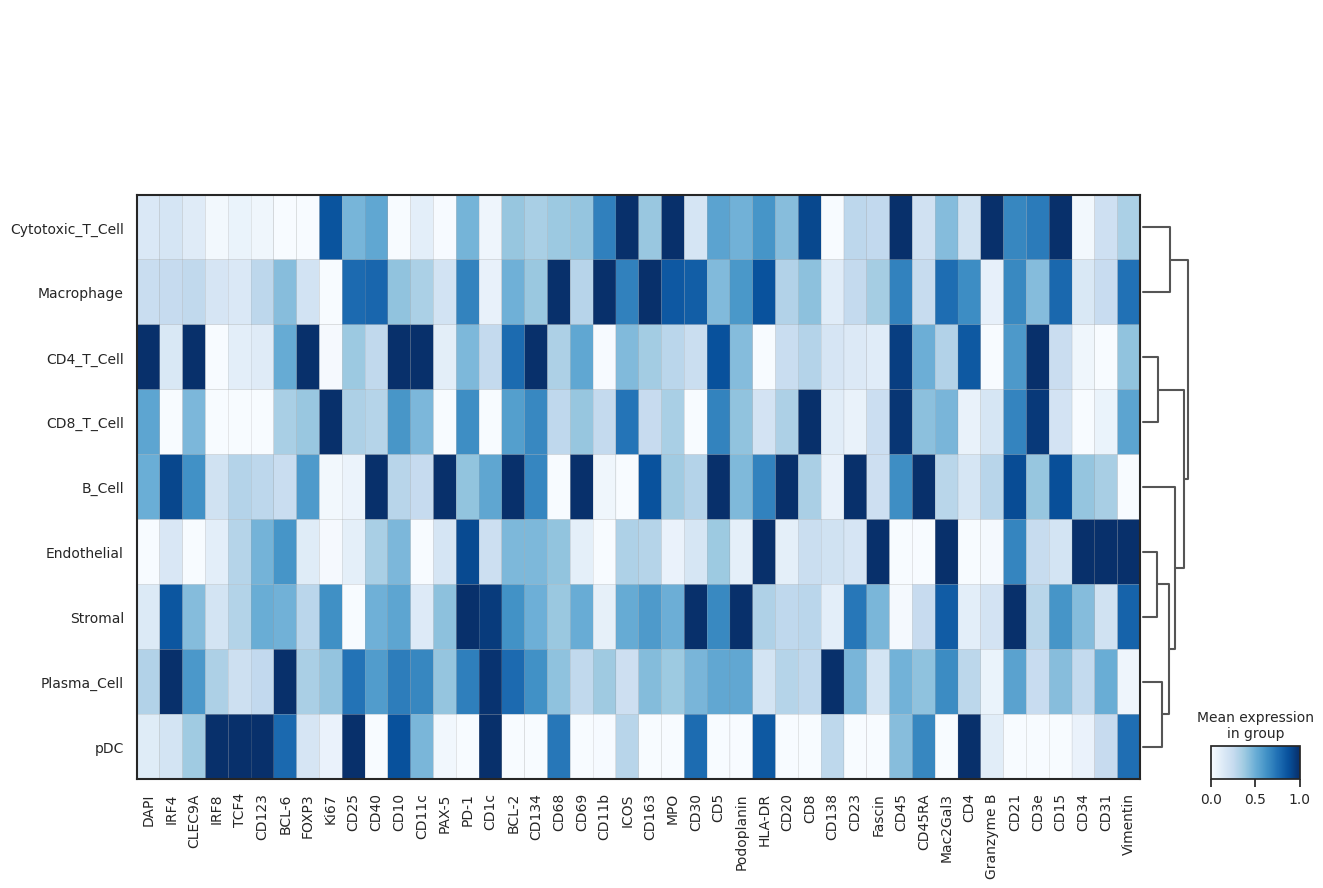

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'cell_type_pred_knn' as categorical
/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'n

In [48]:
# rerunning for some misses
# missing = ['HVCD1', 'HVCD2', 'MCD4', 'R1']
# out_path = '../../outs/neighborhood_analysis/'
# input_list = [(s,p) for s,p in loc_dict.items() if s in missing]
# res = Parallel(6)(delayed(aggr_make_plots)(i, out_path) for i in input_list)
res = aggr_make_plots(input_list[1], out_path)

In [49]:
# Spatial LDA
out_path = '../../outs/neighborhood_analysis/'
plt.ioff()
for s, paths in tqdm.tqdm(loc_dict.items()):
    # if s in ['K3','HVCD1','HVCD2','K2','MCD4','R2','MCD3']:
    #     continue
    print(s)
    # Processing got interrupted
    # if s in ['R2','MCD3','HVCD2','K3','K1']:
    #     continue
    adata = sc.read_h5ad(os.path.join(out_path, s, 'dat.h5ad'))
    adata = sm.tl.spatial_lda(adata, num_motifs=6, radius=50, 
                          imageid='region', x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                          phenotype='new_pheno')
    m = adata.uns['spatial_lda'].columns
    motifs = adata.uns['spatial_lda'].apply(lambda x: m[np.argmax(x)], axis=1)
    adata.obs['motif'] = motifs
    
    # making neigborhood bar charts...
    comp = adata.obs[['new_pheno','motif']].pivot_table(index='new_pheno',columns='motif', 
                                                      aggfunc=len, fill_value=0)
    # reorder cells based on abundance
    comp = comp.loc[adata.obs['new_pheno'].value_counts().index, :]
    
    # realtive abundance
    pdata = comp.apply(lambda x: x/x.sum(), axis=0)
    fig, ax = plt.subplots(figsize=(15,15))
    pdata.T.plot(kind='bar', stacked=True, **{'ax':ax})
    plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
    plt.savefig(os.path.join(out_path, s, 'community_bar_plot.pdf'), bbox_inches="tight")
    plt.close()
    
    # absolute abundance
    fig, ax = plt.subplots(figsize=(15,15))
    comp.T.plot(kind='bar', stacked=True, **{'ax':ax})
    plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
    plt.savefig(os.path.join(out_path, s, 'community_bar_plot_absolute.pdf'), bbox_inches="tight")
    plt.close()
    
    # motifs abun. bar plot
    adata.obs.motif.value_counts().plot.bar()
    plt.savefig(os.path.join(out_path, s, 'motif_abundance.png'), bbox_inches="tight")
    plt.close()
    
    # save everything...
    adata.write(os.path.join(out_path, s, 'dat.h5ad'))

    

  0%|          | 0/10 [00:00<?, ?it/s]

R1
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2562190276204687
Gathering the latent weights


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
 10%|█         | 1/10 [04:12<37:49, 252.20s/it]

K1
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Processing: ['3']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.3114191237488864
Gathering the latent weights
R1
Figure(1500x1000)
K3
Figure(1500x1000)
MCD4
Figure(1500x1000)
MCD1
Figure(1500x1000)
HVCD2
Figure(1500x1000)
R2
Figure(1500x1000)
MCD3
Figure(1500x1000)
K2
Figure(1500x1000)


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
 20%|██        | 2/10 [06:53<26:31, 198.93s/it]

R2
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.24561000599205673
Gathering the latent weights


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
 30%|███       | 3/10 [07:58<16:03, 137.59s/it]

K2
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Processing: ['3']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.3469454391373812
Gathering the latent weights


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
 40%|████      | 4/10 [11:57<17:46, 177.73s/it]

K3
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Processing: ['3']
Identifying neighbours within 50 pixels of every cell
Processing: ['4']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2926565639604051
Gathering the latent weights


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
 50%|█████     | 5/10 [16:07<16:57, 203.60s/it]

MCD4
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Processing: ['3']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.216451977709605
Gathering the latent weights


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
 60%|██████    | 6/10 [21:05<15:43, 235.85s/it]

HVCD2
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Processing: ['3']
Identifying neighbours within 50 pixels of every cell
Processing: ['4']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2679111112727601
Gathering the latent weights


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
 70%|███████   | 7/10 [27:58<14:41, 293.76s/it]

MCD1
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Processing: ['3']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.25434547244523587
Gathering the latent weights


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
 80%|████████  | 8/10 [35:44<11:36, 348.40s/it]

HVCD1
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Processing: ['3']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.29917001350110417
Gathering the latent weights


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
 90%|█████████ | 9/10 [42:13<06:01, 361.18s/it]

MCD3
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2901801892305816
Gathering the latent weights


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
100%|██████████| 10/10 [44:41<00:00, 268.10s/it]


### Disease aggregation

In [96]:

paths = input_list[1][1]
# dat = list(map(lambda x: sc.read_h5ad(os.path.join(x, 'gated_dat.h5ad')), paths))
dat = list(map(lambda x: sc.read_loom(os.path.join(x, 'gated_dat.loom')), paths))
vars = list(map(lambda x: pd.read_csv(os.path.join(x, 'var_dat.csv'), index_col=0), paths))
# var_names = pd.read_csv(os.path.join(paths[0], 'var_names.csv'))
var_names = list(map(lambda x: pd.read_csv(os.path.join(paths[0], 'var_names.csv')), paths))
var_names = [set(df.iloc[:,0]) for df in var_names]
var_names_all = var_names[0].intersection(*var_names)
# dat = list(map(quick_process, dat))
for i in range(len(dat)):
    dat[i].var_names = list(var_names[i])
    dat[i] = dat[i][:,list(var_names_all)]
adata = ad.concat(dat, label="region", index_unique="_")
adata

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_c

AnnData object with n_obs × n_vars = 631096 × 44
    obs: 'Absolute.X', 'Absolute.Y', 'Cell.Size', 'In.Tile.X', 'In.Tile.Y', 'Reg', 'Tile.Col', 'Tile.Row', 'Tile.Z', 'Unnamed: 0', 'cell_type_pred_knn', 'cell_type_pred_knn_prob', 'index_info', 'motif', 'nCount_originalexp', 'nCount_raw', 'nFeature_originalexp', 'nFeature_raw', 'n_genes_by_counts', 'new_pheno', 'obs_names', 'orig.ident', 'total_counts', 'region'

In [89]:
var_names = list(map(lambda x: pd.read_csv(os.path.join(paths[0], 'var_names.csv')), paths))
var_names = [set(df.iloc[:,0]) for df in var_names]
var_names_union = var_names[0].intersection(*var_names)
len(var_names_union)

44

In [86]:
all(["CD69" in l for l in var_names])

True

In [77]:
dat[1].var_names = list(var_names[i])
dat[1].var_names

Index(['Granzyme B', 'BCL-6', 'ICOS', 'CD11b', 'BCL-2', 'PD-1', 'CD138',
       'DAPI', 'CD15', 'CD25', 'CD4', 'CD21', 'PAX-5', 'IRF4', 'Fascin',
       'Podoplanin', 'CD34', 'CLEC9A', 'CD68', 'CD30', 'FOXP3', 'Vimentin',
       'Ki67', 'CD5', 'CD3e', 'IRF8', 'MPO', 'CD123', 'CD134', 'CD163', 'CD45',
       'CD1c', 'CD45RA', 'CD20', 'HLA-DR', 'CD11c', 'CD40', 'TCF4', 'CD8',
       'CD23', 'CD10', 'CD69', 'CD31', 'Mac2Gal3'],
      dtype='object')

In [100]:
res = aggr_make_plots(input_list[0], out_path)

K


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_c

ValueError: Length of passed value for var_names is 47, but this AnnData has shape: (1299061, 41)

In [102]:
out_path = '../../outs/neighborhood_analysis/'
input_list = [(s,p) for s,p in dis_loc_dict.items()]
res = Parallel(4)(delayed(aggr_make_plots)(i, out_path) for i in input_list)

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_c

R
Processing Image: 0
Processing Image: 1
Processing Image: 2
Processing Image: 3
Processing Image: ['0']
Categories (1, object): ['0']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['1']
Categories (1, object): ['1']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['2']
Categories (1, object): ['2']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['3']
Categories (1, object): ['3']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Figure(1500x1000)


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_c

K
Processing Image: 0
Processing Image: 1
Processing Image: 2
Processing Image: 3
Processing Image: 4
Processing Image: 5
Processing Image: 6
Processing Image: 7
Processing Image: 8
Processing Image: 9
Processing Image: 10
Processing Image: 11
Processing Image: 12
Processing Image: ['0']
Categories (1, object): ['0']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['1']
Categories (1, object): ['1']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['2']
Categories (1, object): ['2']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['3']
Categories (1, object): ['3']
Identifying neighbours within 50 pixels of every cell
Mapping p

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_c

MCD
Processing Image: 0
Processing Image: 1
Processing Image: 2
Processing Image: 3
Processing Image: 4
Processing Image: 5
Processing Image: 6
Processing Image: 7
Processing Image: 8
Processing Image: 9
Processing Image: 10
Processing Image: ['0']
Categories (1, object): ['0']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['1']
Categories (1, object): ['1']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['2']
Categories (1, object): ['2']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['3']
Categories (1, object): ['3']
Identifying neighbours within 50 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 pe

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_c

In [ ]:
out_path = '../../outs/neighborhood_analysis/'
plt.ioff()
for s, paths in tqdm.tqdm(dis_loc_dict.items()):
    if not os.path.isdir(os.path.join(out_path, s)):
        os.mkdir(os.path.join(out_path, s))
    
    dat = list(map(lambda x: sc.read_h5ad(os.path.join(x, 'dat.h5ad')), paths))
    adata = ad.concat(dat, label="region", index_unique="_")
    
    print('doing the scimap stuff')
    adata = sm.tl.spatial_distance(adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                               phenotype='cell_type_pred_knn', imageid='region')
    sm.pl.spatial_distance(adata, phenotype='cell_type_pred_knn', heatmap_standard_scale=1)
    plt.savefig(os.path.join(out_path, s, 'dist_heatmap.pdf'))
    plt.close()
    adata = sm.tl.spatial_interaction(adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                               phenotype='cell_type_pred_knn', imageid='region',
                              method='knn')
    sm.pl.spatial_interaction(adata)
    plt.savefig(os.path.join(out_path, s, 'intxn_heatmap.pdf'))
    plt.close()
    
    adata = sm.tl.spatial_lda(adata, num_motifs=10, radius=100, 
                          imageid='region', x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                          phenotype='cell_type_pred_knn')
    m = adata.uns['spatial_lda'].columns
    motifs = adata.uns['spatial_lda'].apply(lambda x: m[np.argmax(x)], axis=1)
    adata.obs['motif'] = motifs
    
    # making neigborhood bar charts...
    comp = adata.obs[['cell_type_pred_knn','motif']].pivot_table(index='cell_type_pred_knn',columns='motif', 
                                                      aggfunc=len, fill_value=0)
    pdata = comp.apply(lambda x: x/x.sum(), axis=0)

    fig, ax = plt.subplots(figsize=(15,15))
    pdata.T.plot(kind='bar', stacked=True, **{'ax':ax})
    plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
    plt.savefig(os.path.join(out_path, s, 'community_bar_plot.pdf'))
    plt.close()
    
    # save everything...
    adata.write(os.path.join(out_path, s, 'dat.h5ad'))
    

  0%|          | 0/4 [00:00<?, ?it/s]/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transfo

doing the scimap stuff
Processing Image: 0
Processing Image: 1
Processing Image: 2
Processing Image: 3
Processing Image: 4
Processing Image: 5
Processing Image: 6
Processing Image: ['0']
Categories (1, object): ['0']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['1']
Categories (1, object): ['1']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['2']
Categories (1, object): ['2']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['3']
Categories (1, object): ['3']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image:

/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'cell_type_pred_knn' as categorical
/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
 25%|██▌       | 1/4 [30:36<1:31:48, 1836.27s/it]/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning:

Transforming to str index.

/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/anndat

doing the scimap stuff
Processing Image: 0
Processing Image: 1
Processing Image: 2
Processing Image: 3
Processing Image: 4
Processing Image: 5
Processing Image: 6
Processing Image: ['0']
Categories (1, object): ['0']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['1']
Categories (1, object): ['1']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['2']
Categories (1, object): ['2']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['3']
Categories (1, object): ['3']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image:

In [103]:
# Spatial LDA
out_path = '../../outs/neighborhood_analysis/'
plt.ioff()
for s, paths in tqdm.tqdm(dis_loc_dict.items()):
    print(s)
    # Processing got interrupted
    # if s in ['R2','MCD3','HVCD2','K3','K1']:
    #     continue
    adata = sc.read_h5ad(os.path.join(out_path, s, 'dat.h5ad'))
    adata = sm.tl.spatial_lda(adata, num_motifs=6, radius=50, 
                          imageid='region', x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                          phenotype='cell_type_pred_knn')
    m = adata.uns['spatial_lda'].columns
    motifs = adata.uns['spatial_lda'].apply(lambda x: m[np.argmax(x)], axis=1)
    adata.obs['motif'] = motifs
    
    # making neigborhood bar charts...
    comp = adata.obs[['cell_type_pred_knn','motif']].pivot_table(index='cell_type_pred_knn',columns='motif', 
                                                      aggfunc=len, fill_value=0)
    # reorder cells based on abundance
    comp = comp.loc[adata.obs['cell_type_pred_knn'].value_counts().index, :]
    
    # realtive abundance
    pdata = comp.apply(lambda x: x/x.sum(), axis=0)
    fig, ax = plt.subplots(figsize=(15,15))
    pdata.T.plot(kind='bar', stacked=True, **{'ax':ax})
    plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
    plt.savefig(os.path.join(out_path, s, 'community_bar_plot.pdf'), bbox_inches="tight")
    plt.close()
    
    # absolute abundance
    fig, ax = plt.subplots(figsize=(15,15))
    comp.T.plot(kind='bar', stacked=True, **{'ax':ax})
    plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
    plt.savefig(os.path.join(out_path, s, 'community_bar_plot_absolute.pdf'), bbox_inches="tight")
    plt.close()
    
    # motifs abun. bar plot
    adata.obs.motif.value_counts().plot.bar()
    plt.savefig(os.path.join(out_path, s, 'motif_abundance.png'), bbox_inches="tight")
    plt.close()
    
    # save everything...
    adata.write(os.path.join(out_path, s, 'dat.h5ad'))

    

  0%|          | 0/4 [00:00<?, ?it/s]

K
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Processing: ['3']
Identifying neighbours within 50 pixels of every cell
Processing: ['4']
Identifying neighbours within 50 pixels of every cell
Processing: ['5']
Identifying neighbours within 50 pixels of every cell
Processing: ['6']
Identifying neighbours within 50 pixels of every cell
Processing: ['7']
Identifying neighbours within 50 pixels of every cell
Processing: ['8']
Identifying neighbours within 50 pixels of every cell
Processing: ['9']
Identifying neighbours within 50 pixels of every cell
Processing: ['10']
Identifying neighbours within 50 pixels of every cell
Processing: ['11']
Identifying neighbours within 50 pixels of every cell
Processing: ['12']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
 25%|██▌       | 1/4 [10:24<31:13, 624.61s/it]

R
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Processing: ['3']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.21613162679343564
Gathering the latent weights


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
 50%|█████     | 2/4 [16:04<15:13, 456.99s/it]

MCD
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Processing: ['3']
Identifying neighbours within 50 pixels of every cell
Processing: ['4']
Identifying neighbours within 50 pixels of every cell
Processing: ['5']
Identifying neighbours within 50 pixels of every cell
Processing: ['6']
Identifying neighbours within 50 pixels of every cell
Processing: ['7']
Identifying neighbours within 50 pixels of every cell
Processing: ['8']
Identifying neighbours within 50 pixels of every cell
Processing: ['9']
Identifying neighbours within 50 pixels of every cell
Processing: ['10']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.26704354493787125
Gathering the latent weights


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
 75%|███████▌  | 3/4 [28:55<10:00, 600.66s/it]

HVCD
Processing: ['0']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Processing: ['3']
Identifying neighbours within 50 pixels of every cell
Processing: ['4']
Identifying neighbours within 50 pixels of every cell
Processing: ['5']
Identifying neighbours within 50 pixels of every cell
Processing: ['6']
Identifying neighbours within 50 pixels of every cell
Processing: ['7']
Identifying neighbours within 50 pixels of every cell
Processing: ['8']
Identifying neighbours within 50 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2743691112266851
Gathering the latent weights


/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'motif' as categorical
100%|██████████| 4/4 [42:11<00:00, 633.00s/it]


## cell-cell interactions
To avoid confusing the overlapping image space, going to averge the proabblities across images

In [ ]:
# parallelize
def disease_make_plots(s, paths):
    dat = list(map(lambda x: sc.read_h5ad(os.path.join(x, 'dat.h5ad')), paths))
    adata = ad.concat(dat, label="region", index_unique="_")
    
    print('doing the scimap stuff')
    adata = sm.tl.spatial_distance(adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                               phenotype='cell_type_pred_knn', imageid='region')
    sm.pl.spatial_distance(adata, phenotype='cell_type_pred_knn', heatmap_standard_scale=1)
    plt.savefig(os.path.join(out_path, s, 'dist_heatmap.pdf'))
    plt.close()
    adata = sm.tl.spatial_interaction(adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                               phenotype='cell_type_pred_knn', imageid='region',
                              method='knn')
    sm.pl.spatial_interaction(adata)
    plt.savefig(os.path.join(out_path, s, 'intxn_heatmap.pdf'))
    plt.close()
    
    adata = sm.tl.spatial_lda(adata, num_motifs=10, radius=100, 
                          imageid='region', x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                          phenotype='cell_type_pred_knn')
    m = adata.uns['spatial_lda'].columns
    motifs = adata.uns['spatial_lda'].apply(lambda x: m[np.argmax(x)], axis=1)
    adata.obs['motif'] = motifs
    
    # making neigborhood bar charts...
    comp = adata.obs[['cell_type_pred_knn','motif']].pivot_table(index='cell_type_pred_knn',columns='motif', 
                                                      aggfunc=len, fill_value=0)
    pdata = comp.apply(lambda x: x/x.sum(), axis=0)

    fig, ax = plt.subplots(figsize=(15,15))
    pdata.T.plot(kind='bar', stacked=True, **{'ax':ax})
    plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
    plt.savefig(os.path.join(out_path, s, 'community_bar_plot.pdf'))
    plt.close()
    
    # motifs abun. bar plot
    adata.obs.motif.value_counts().plot.bar()
    plt.savefig(os.path.join(out_path, s, 'motif_abundance.png'), bbox_inches="tight")
    plt.close()
    
    # cell type abundance bar plot
    adata.obs.cell_type_pred_knn.value_counts().plot.bar()
    plt.savefig(os.path.join(out_path, s, 'cell_type_abundance.png'), bbox_inches="tight")
    plt.close()
    
    # save everything...
    adata.write(os.path.join(out_path, s, 'dat.h5ad'))
    return None

### Cell-cell interactions


In [2]:
# parallelize

def cc_intxn_aggr(s, out_path):
# for s, paths in tqdm.tqdm(dis_loc_dict.items()):
    adata = sc.read_h5ad(os.path.join(out_path, s, 'dat.h5ad'))
    itxn_dir = os.path.join(out_path, s, 'cell-cell_itxn')
    if not os.path.isdir(itxn_dir):
        os.mkdir(itxn_dir)
    cc_itxn_dict = {}
    for c in adata.obs['new_pheno'].unique():
        if not os.path.isdir(os.path.join(itxn_dir,c)):
            os.mkdir(os.path.join(itxn_dir,c))
        for cc in adata.obs['new_pheno'].unique():
            if c == cc:
                continue
            if np.sum(adata.obs['new_pheno']==c) < 100 or np.sum(adata.obs['new_pheno']==cc) < 100:
                continue
            c_key = c + ' -- ' + cc
            cc_itxn_dict[c_key] = []
            dat_dict = {}
            for r in adata.obs.region.unique():
                adata_sub = adata[adata.obs.region == r,:].copy()
                ref_dat = adata_sub.obs.loc[adata_sub.obs['new_pheno']==c, ['Absolute.Y', 'Absolute.X']]
                q_dat = adata_sub.obs.loc[adata_sub.obs['new_pheno']==cc, ['Absolute.Y', 'Absolute.X']]
                ref_tree = sci.spatial.cKDTree(ref_dat)
                dist_res = ref_tree.query(q_dat, k=1)
                ecdf = ECDF(dist_res[0])
                csr_dat = pd.DataFrame(simdata(adata_sub, ref_dat, q_dat, ecdf)).T
                df = pd.concat([csr_dat, pd.Series(ecdf(csr_dat[0]))], axis=1)
                df.columns = ['dist', 'csr', 'ecdf']
                dat_dict[r] = df
            for r, df in dat_dict.items():
                if r == '0':
                    merge_df = df
                else:
                    merge_df = merge_df.join(df, rsuffix=r)
            merge_df['ecdf_avg'] = merge_df.filter(regex='ecdf').apply(np.mean, axis=1)
            merge_df['csr_avg'] = merge_df.filter(regex='csr').apply(np.mean, axis=1)
            cc_itxn_dict[c_key].append(merge_df['dist'][np.argmin(np.absolute(merge_df['ecdf_avg']-0.5))])
            stat = sci.stats.ks_2samp(merge_df['ecdf_avg'], merge_df['csr_avg'])
            cc_itxn_dict[c_key].append(stat[1])
            
            plt.plot(merge_df['dist'], merge_df['csr_avg'])
            plt.plot(merge_df['dist'], merge_df['ecdf_avg'], c='red')
            plt.savefig(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.png'))
            plt.close()
    cc_df = pd.DataFrame(cc_itxn_dict).T
    cc_df.columns = ['avg_distance', 'p_val']
    cc_df['p_val_adj'] = multipletests(cc_df['p_val'], method='bonferroni')[1]
    cc_df.to_csv(os.path.join(itxn_dir, "stats.csv"))
    
    return None

In [14]:
out_path = '/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis/'
input_list = [(s,p) for s,p in loc_dict.items()]
res = Parallel(8)(delayed(cc_intxn_aggr)(i[0], out_path) for i in input_list)

In [15]:
out_path = '/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis/'
input_list = [(s,p) for s,p in dis_loc_dict.items()]
res = Parallel(4)(delayed(cc_intxn_aggr)(i[0], out_path) for i in input_list)

### Aggregated disease

In [5]:
out_path = '/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis/'
adata_R = sc.read_h5ad(os.path.join(out_path, 'R/dat.h5ad'))
adata_KFD = sc.read_h5ad(os.path.join(out_path, 'K/dat.h5ad'))
adata_KFD

AnnData object with n_obs × n_vars = 794865 × 41
    obs: 'Unnamed: 0', 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Reg', 'Tile.Row', 'Tile.Col', 'Tile.Z', 'In.Tile.Y', 'In.Tile.X', 'Absolute.Y', 'Absolute.X', 'Cell.Size', 'n_genes_by_counts', 'total_counts', 'nCount_raw', 'nFeature_raw', 'cell_type_pred_knn', 'cell_type_pred_knn_prob', 'motif', 'index_info', 'region'
    uns: 'spatial_distance', 'spatial_interaction', 'spatial_lda', 'spatial_lda_probability'

In [6]:
adata = ad.concat([adata_R, adata_KFD], label="disease", index_unique="_")

In [10]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

In [11]:
adata

AnnData object with n_obs × n_vars = 1440150 × 38
    obs: 'Unnamed: 0', 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Reg', 'Tile.Row', 'Tile.Col', 'Tile.Z', 'In.Tile.Y', 'In.Tile.X', 'Absolute.Y', 'Absolute.X', 'Cell.Size', 'n_genes_by_counts', 'total_counts', 'nCount_raw', 'nFeature_raw', 'cell_type_pred_knn', 'cell_type_pred_knn_prob', 'motif', 'index_info', 'region', 'disease'
    var: 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

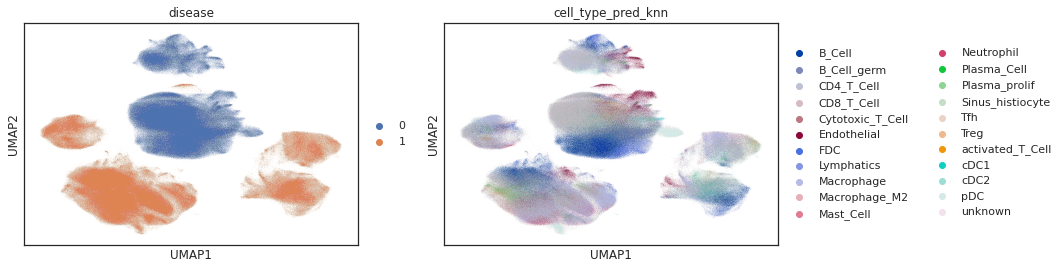

In [17]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
# ax = ax.ravel()
# sc.pl.umap(adata, color='disease', ax=ax[0])
# sc.pl.umap(adata, color='cell_type_pred_knn', ax=ax[1])
# fig.savefig('umap_R-KFD_disease_celltype.png',dpi=300)
sc.pl.umap(adata, color=['disease', 'cell_type_pred_knn'], save='R+KFD_dis_ct.png')

In [13]:
# making the heatmap
sc.tl.dendrogram(adata, n_pcs=10, groupby='cell_type_pred_knn')

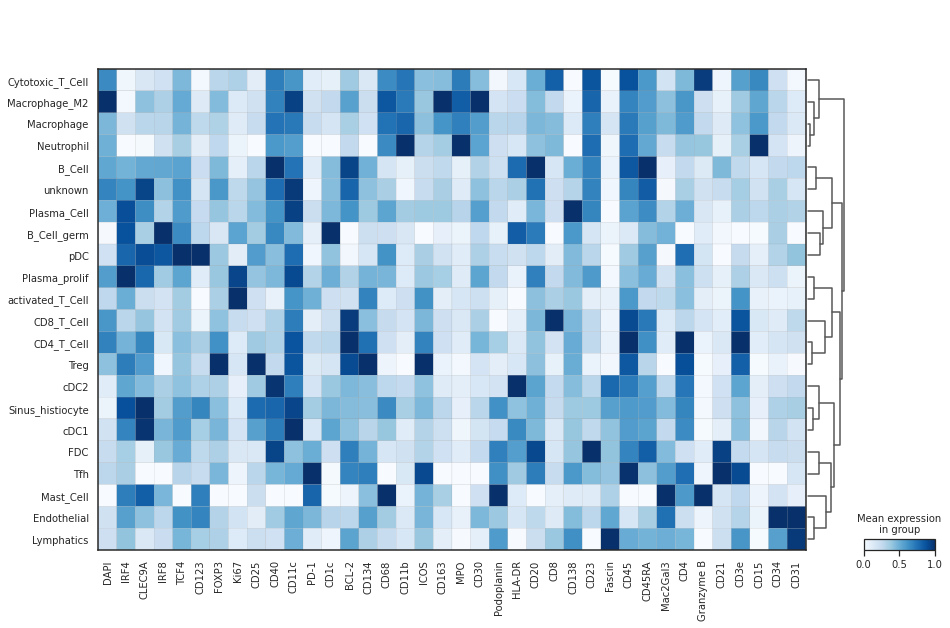

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
sc.pl.matrixplot(adata, adata.var_names, groupby='cell_type_pred_knn', dendrogram=True, cmap='Blues',
             use_raw=True, standard_scale='var', swap_axes=False, ax=ax)
fig.savefig(os.path.join(out_path, 'R_KFD_marker_heatmap.pdf'), dpi=300)